<a href="https://colab.research.google.com/github/ethanelkaim/Deep-Learning-Models/blob/main/VAE_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

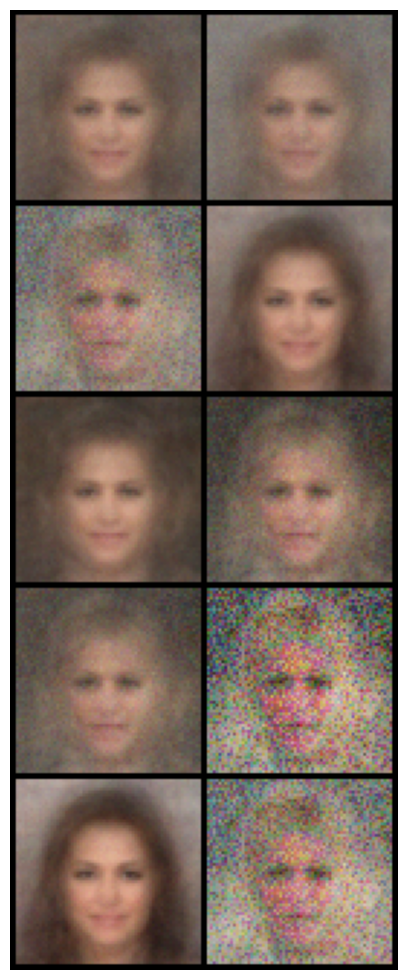

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as trans
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import pickle

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(12288, 512)
        self.mu_layer = nn.Linear(512, latent_dims)
        self.logvar_layer = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 12288)
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 64, 64))

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


def reproduce_hw3():
    z_dim = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    autoencoder = VariationalAutoencoder(z_dim).to(device)

    weights = torch.load('autoencoder_weights.pkl', map_location=device)
    autoencoder.load_state_dict(weights)

    autoencoder.eval()

    z_sample = torch.randn(10, z_dim).to(device)
    with torch.no_grad():
        reconst_images = autoencoder.decoder(z_sample)

    reconst_images = reconst_images.cpu().view(reconst_images.size(0), 3, 64, 64)
    grid_img = torchvision.utils.make_grid(reconst_images, nrow=2)
    plt.figure(figsize=(5, 20))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

reproduce_hw3()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as trans
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 12288)
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 64, 64))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(12288, 512)
        self.mu_layer = nn.Linear(512, latent_dims)
        self.logvar_layer = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)
        return mu, logvar


In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [ ]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
    losses = []
    kl_divergences = []
    for epoch in range(epochs):
        epoch_losses = []
        epoch_kl_divergences = []
        for x, _ in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat, mu, logvar = autoencoder(x)
            recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_div
            loss.backward()
            opt.step()
            epoch_losses.append(recon_loss.item())
            epoch_kl_divergences.append(kl_div.item())

            mu, logvar = autoencoder.encoder(x)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            epoch_kl_divergences.append(kl_div.item())

        epoch_loss = np.mean(epoch_losses)
        losses.append(epoch_loss)

        img = x_hat.data[0].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f'Epoch {epoch + 1}')
        plt.axis('off')
        # plt.savefig(f'epoch_{epoch + 1}.png')
        plt.show()

        kl_div_epoch_mean = np.mean(epoch_kl_divergences)
        kl_divergences.append(kl_div_epoch_mean)

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Reconstruction Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(kl_divergences, label='KL Divergence')
    plt.title('KL Divergence Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Divergence')
    plt.legend()
    plt.show()
    return autoencoder


In [ ]:
z_dim = 2
autoencoder = VariationalAutoencoder(z_dim).to(device) # GPU

transform = trans.Compose([trans.Resize(64), trans.CenterCrop(64), trans.ToTensor()])

path = '/content/drive/My Drive/data_hw3'

train_dataset = ImageFolder(root=path, transform=transform)
data_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

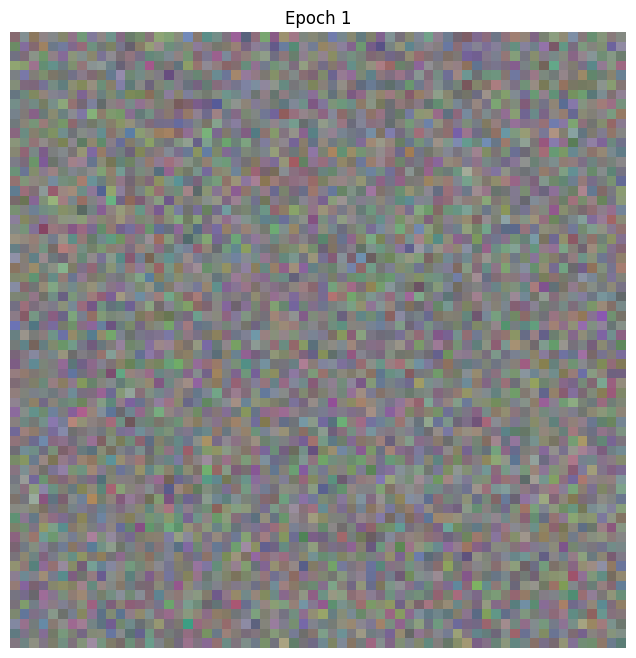

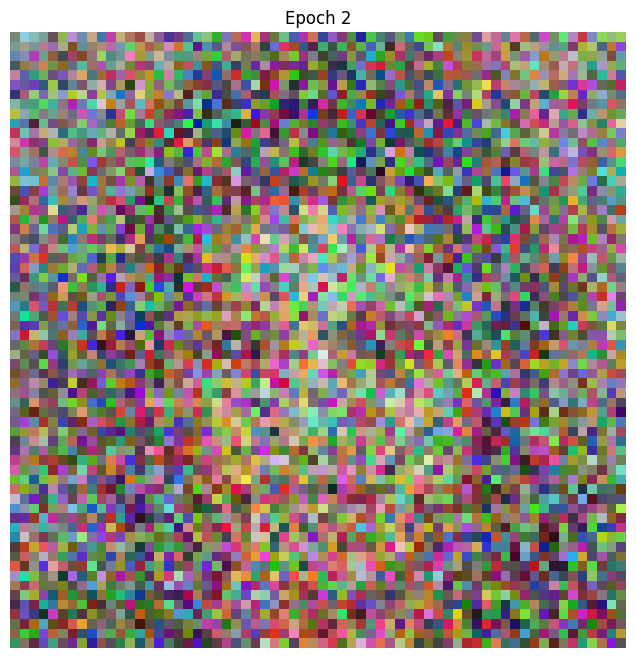

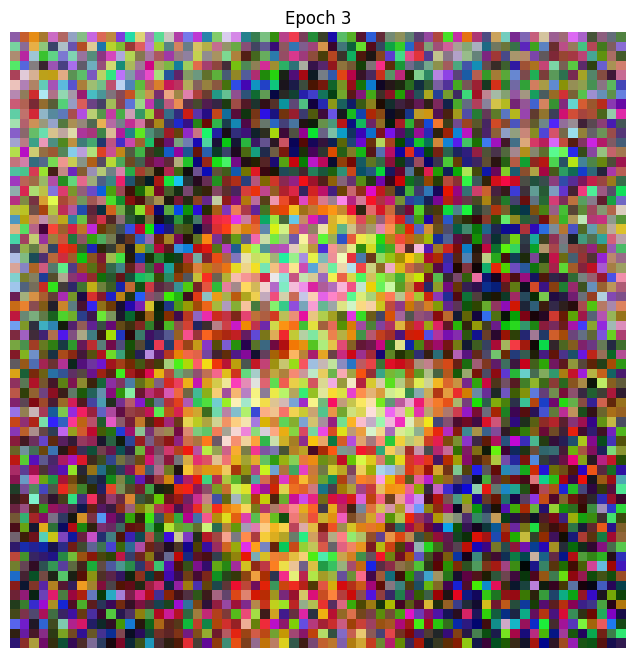

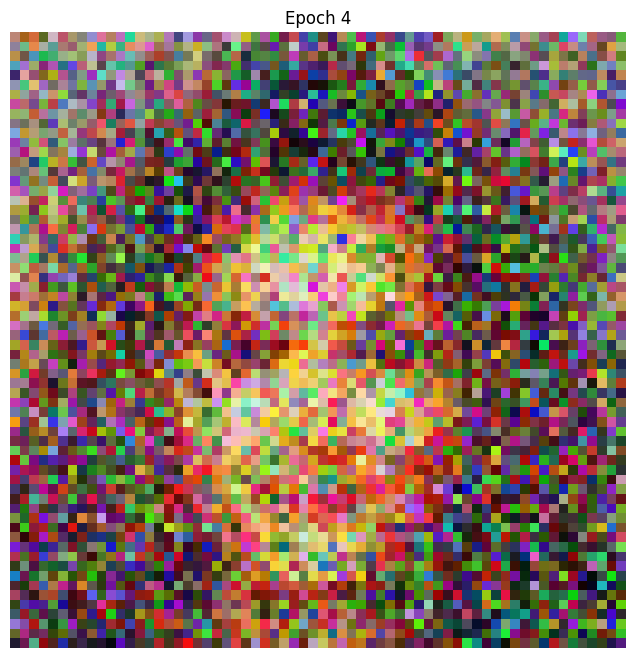

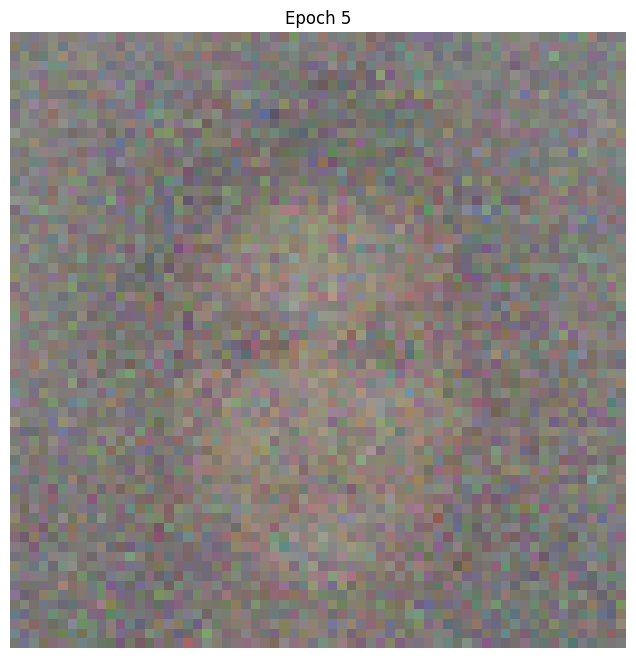

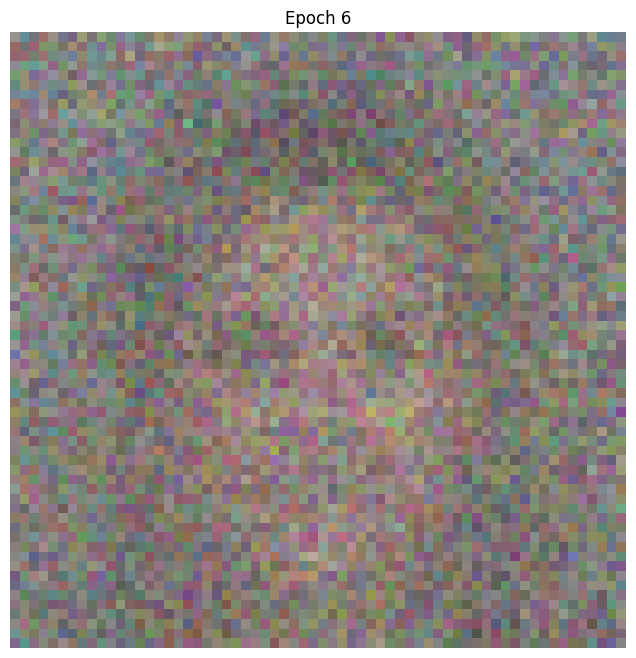

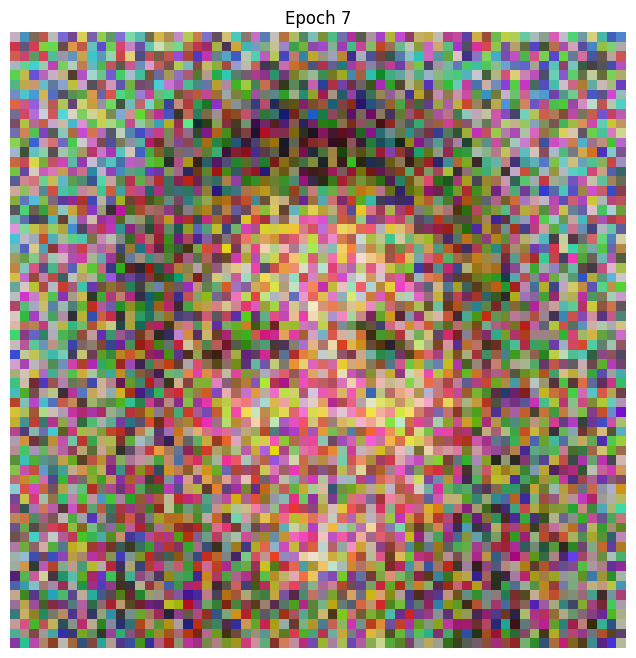

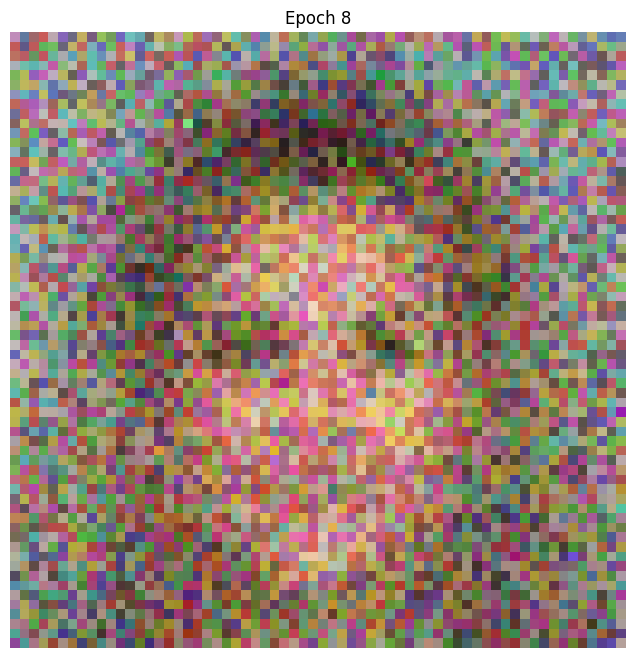

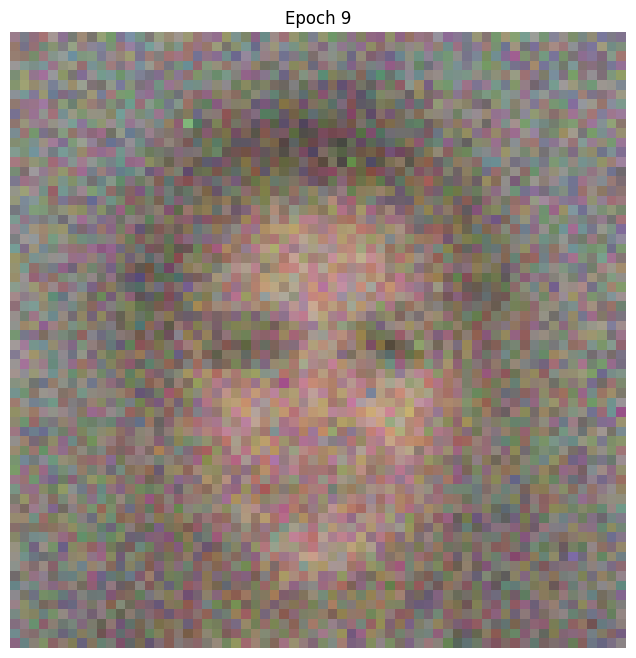

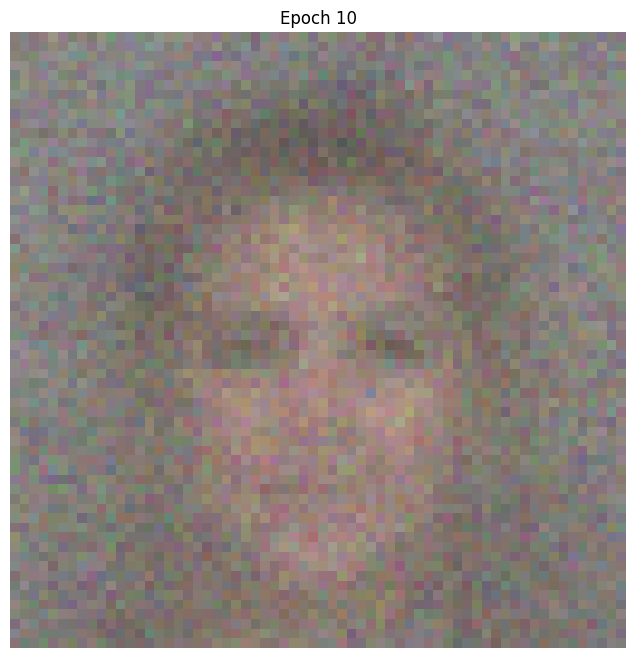

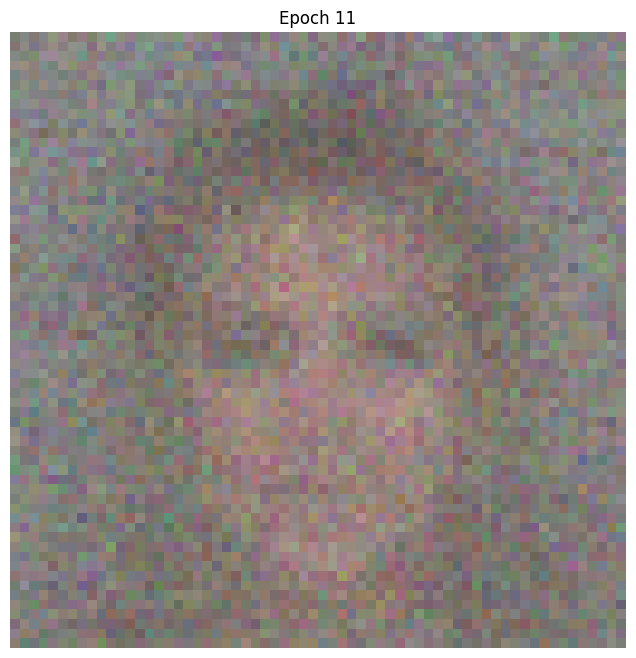

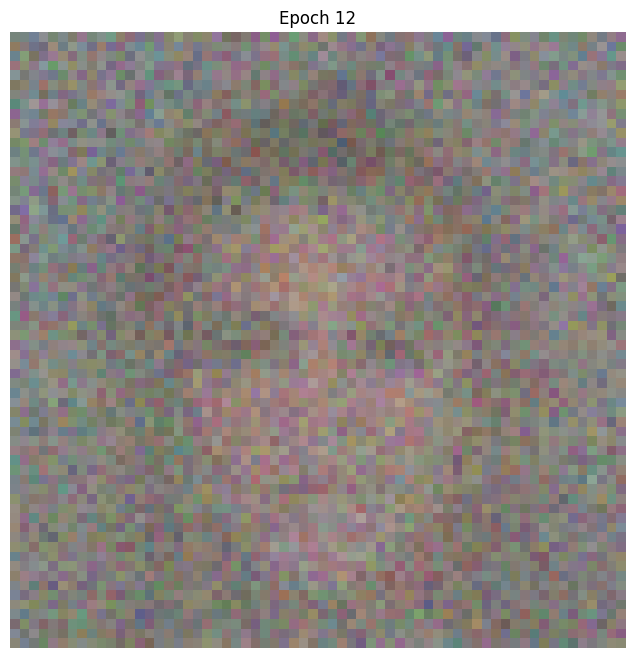

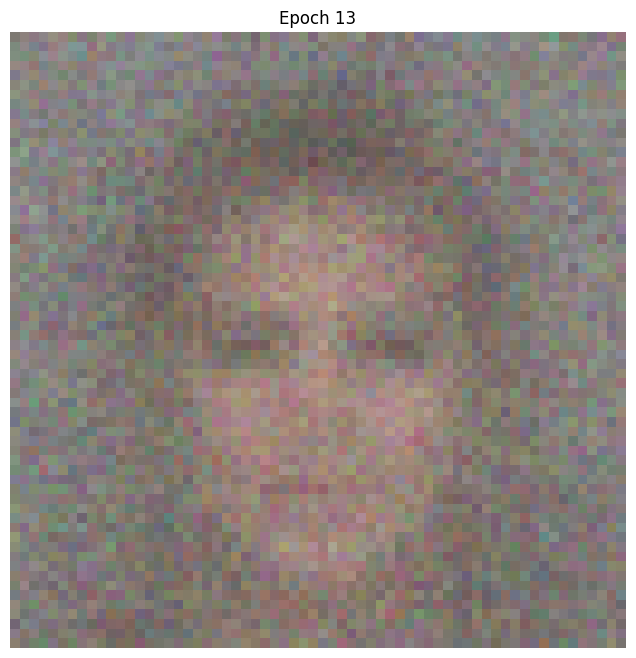

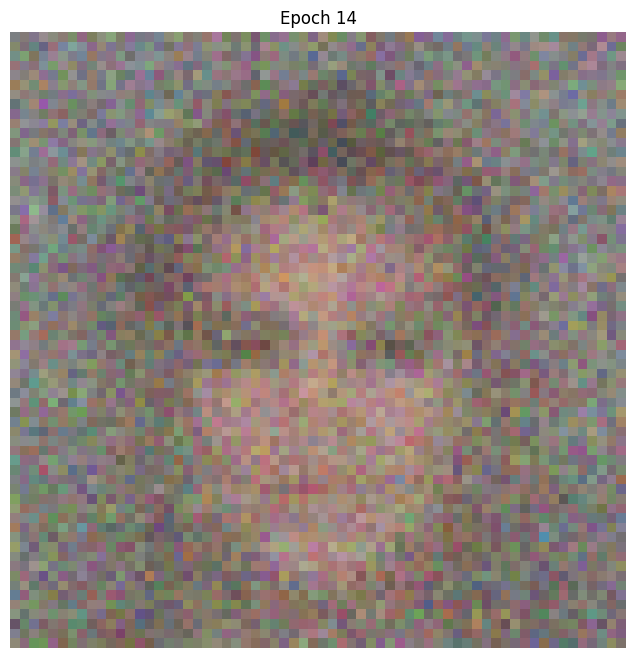

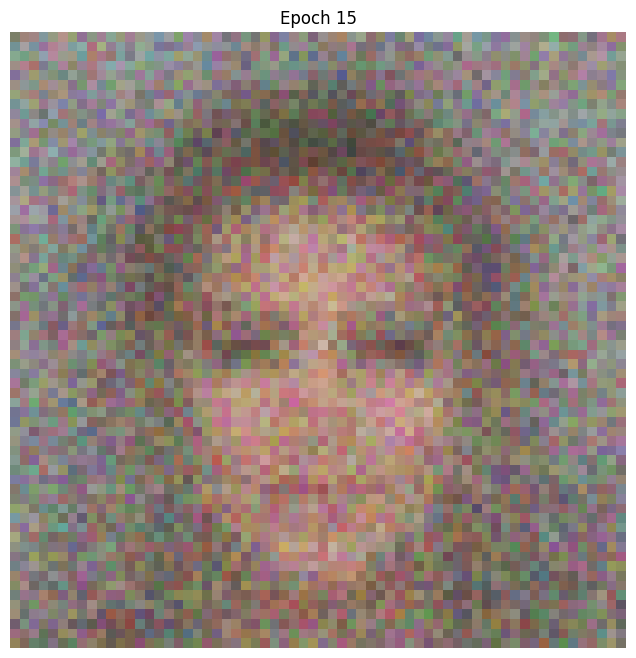

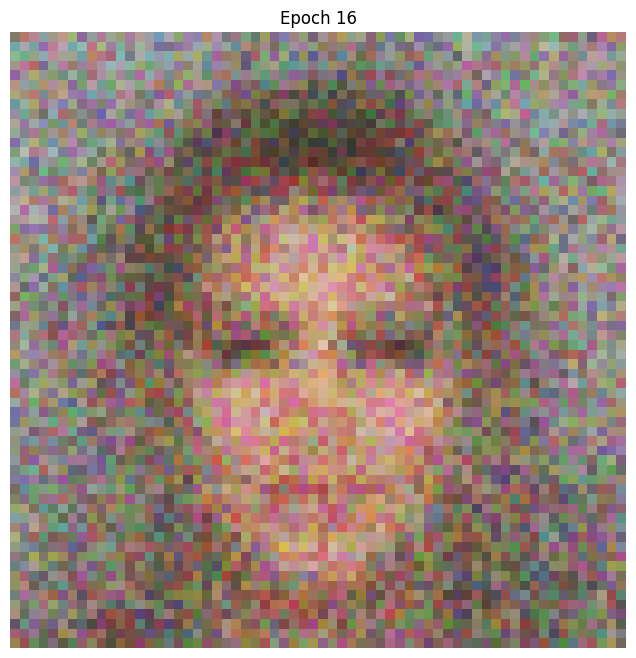

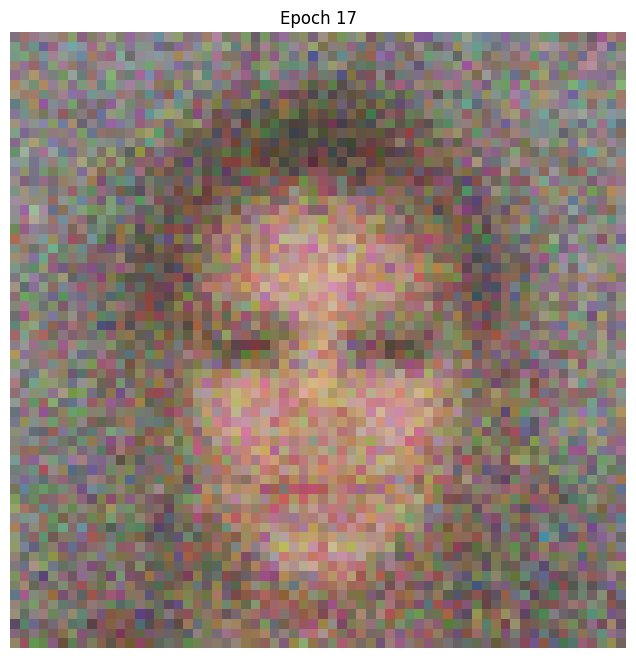

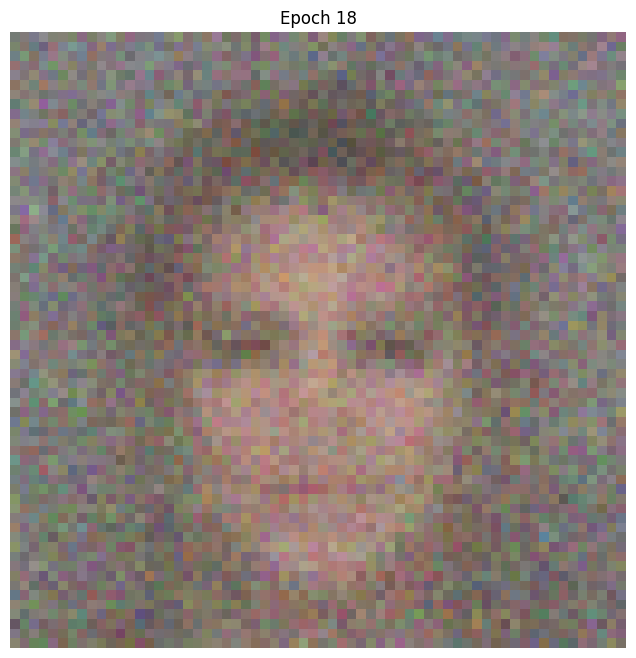

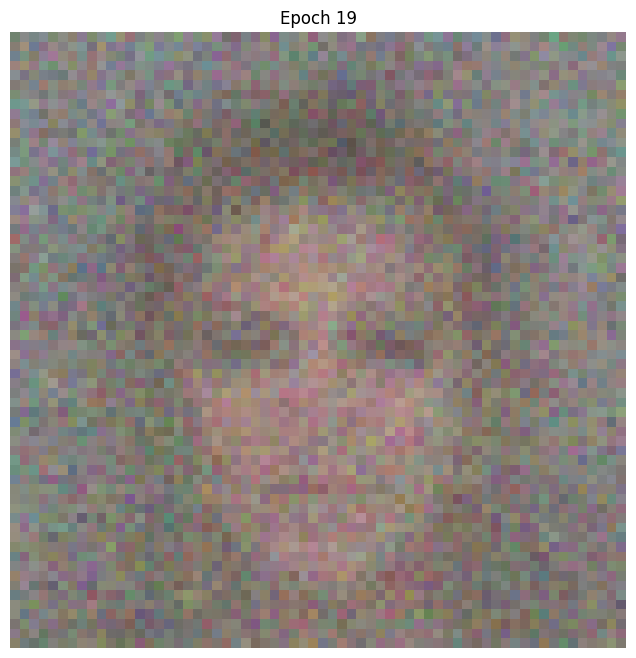

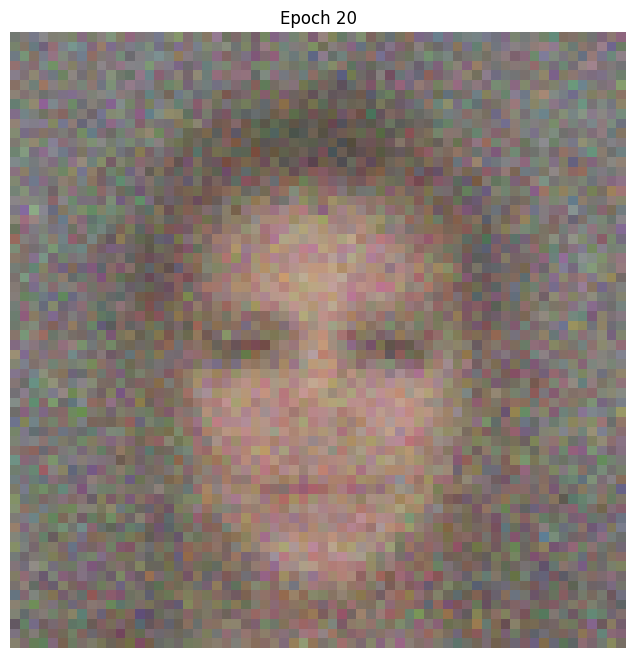

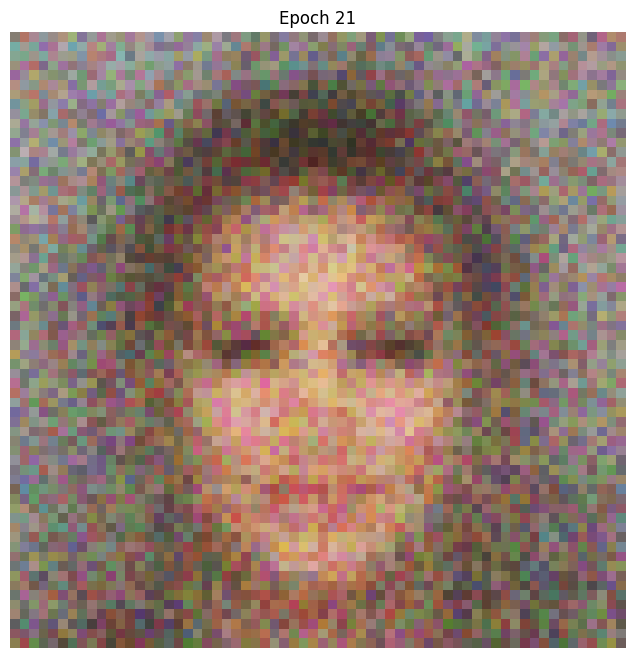

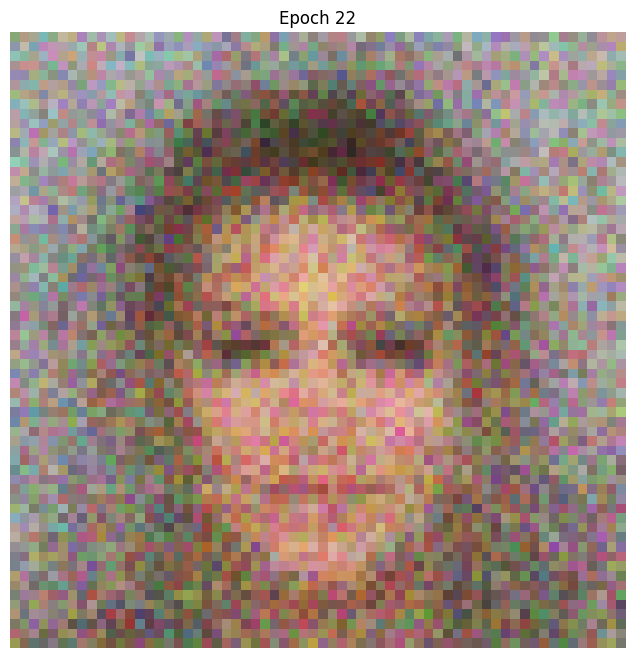

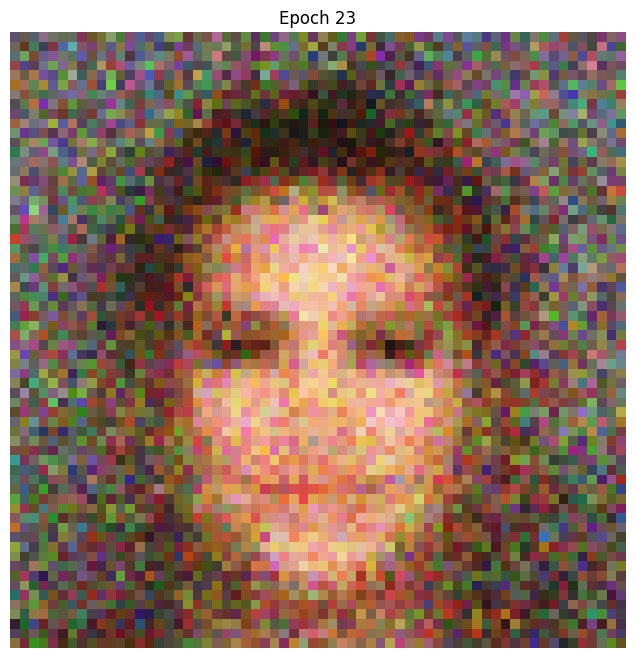

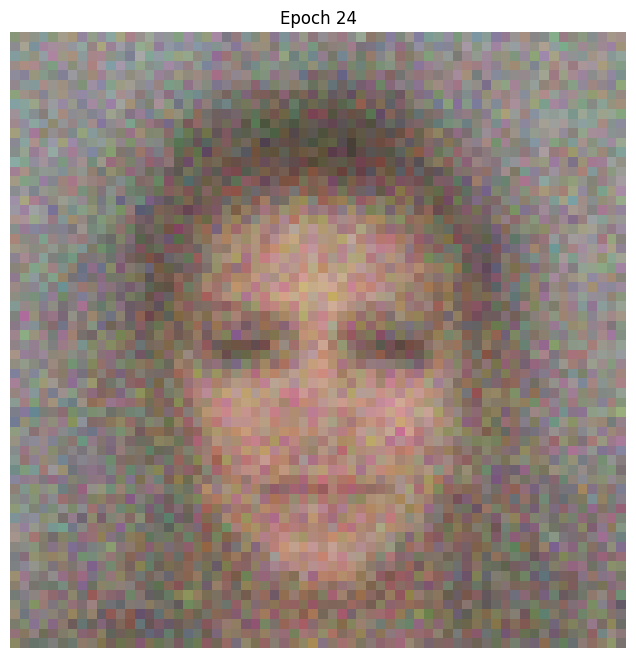

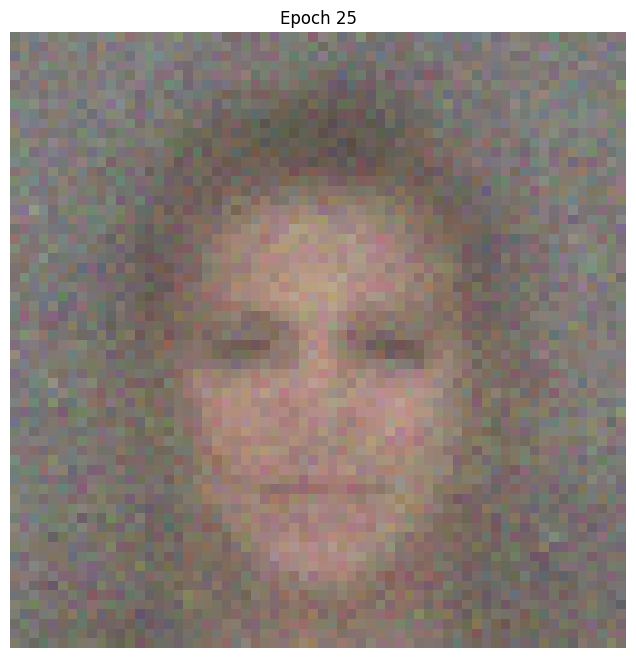

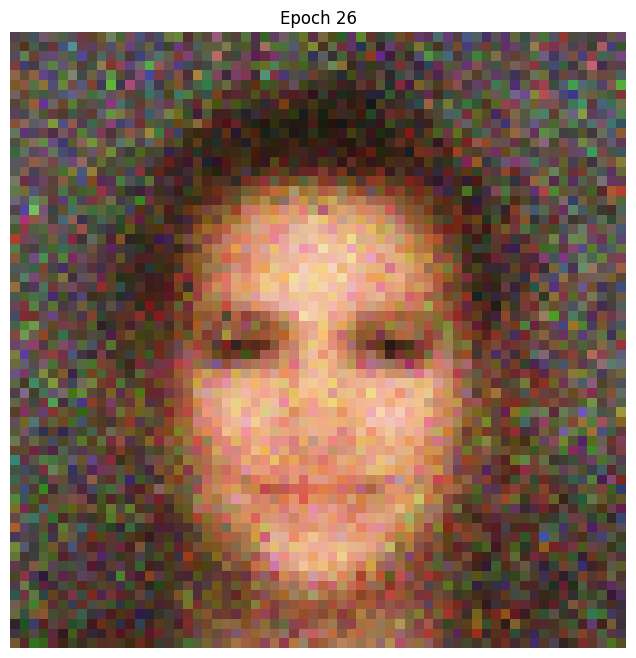

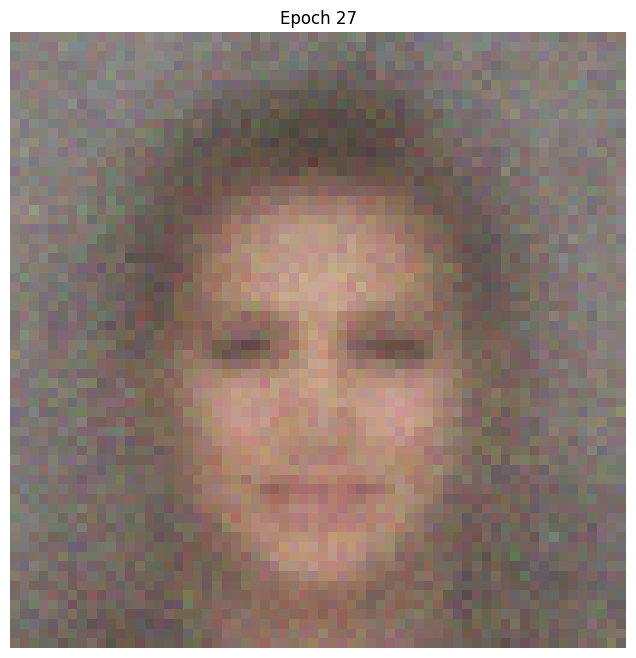

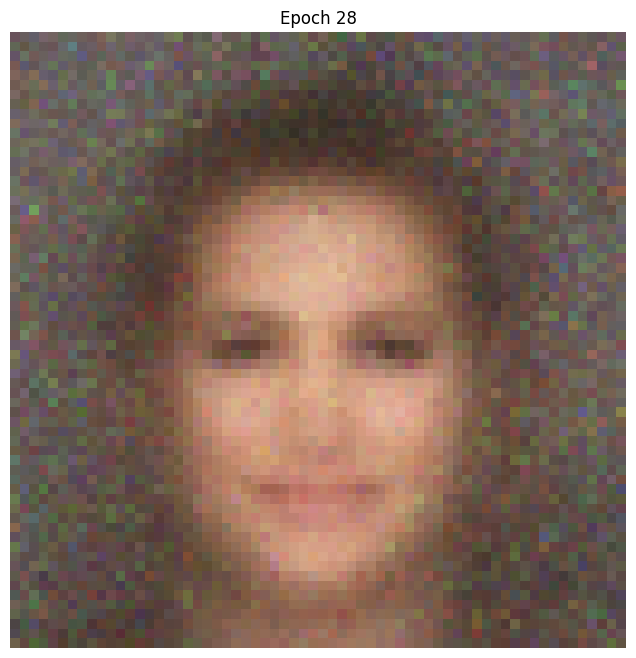

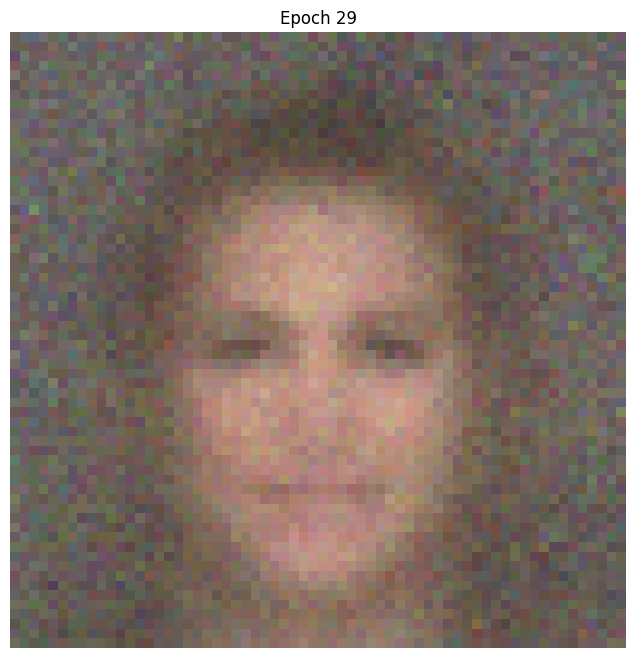

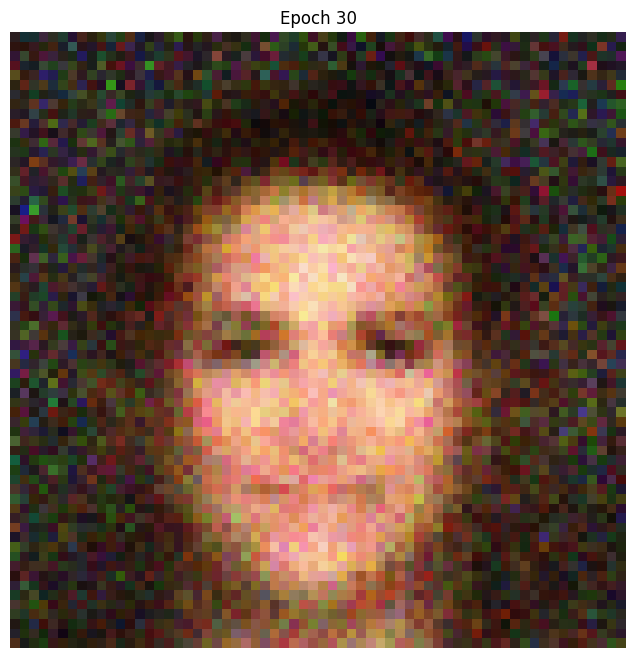

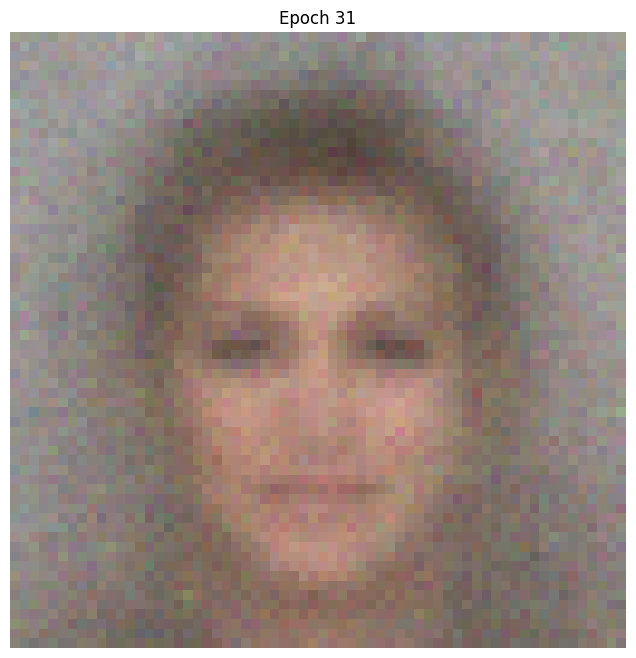

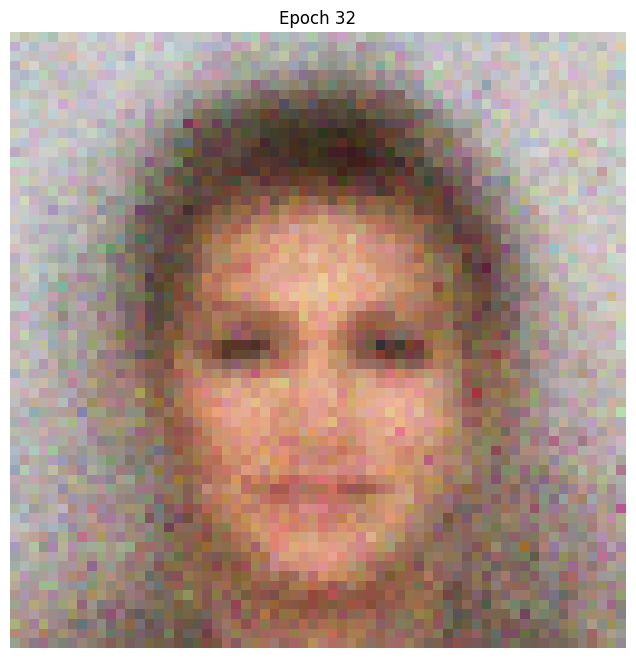

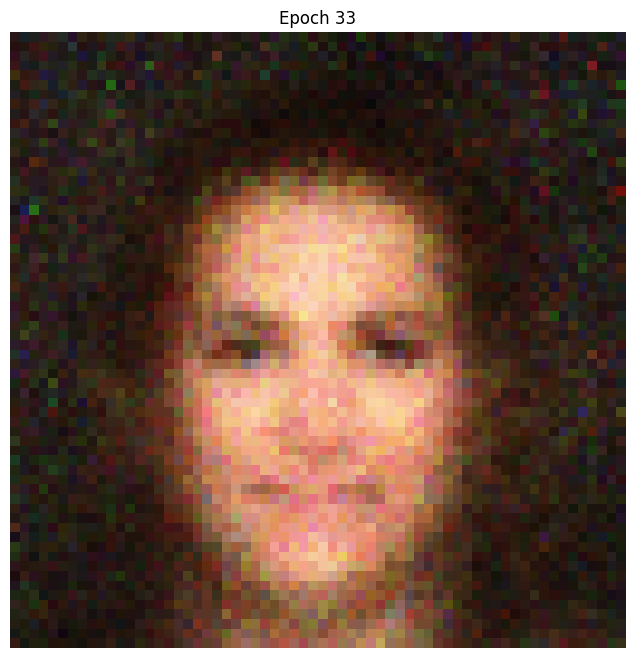

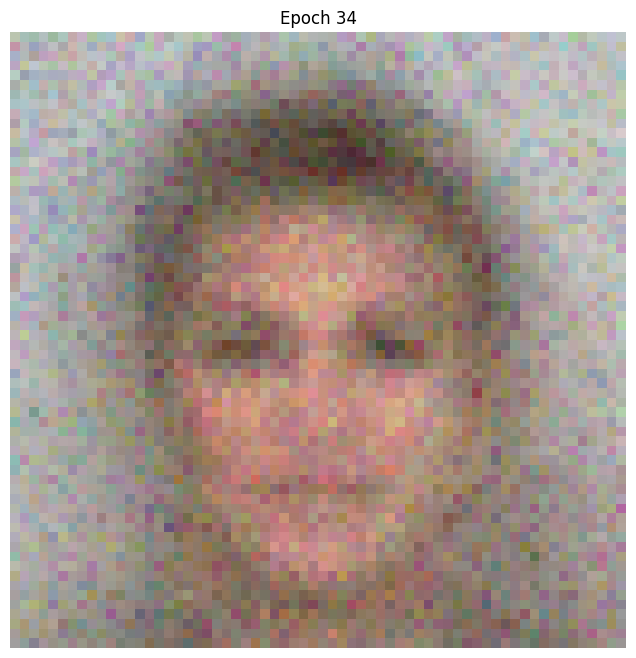

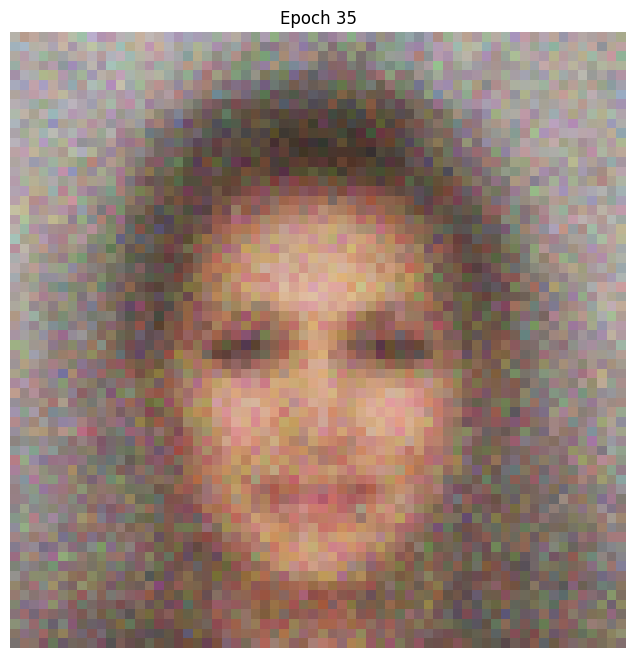

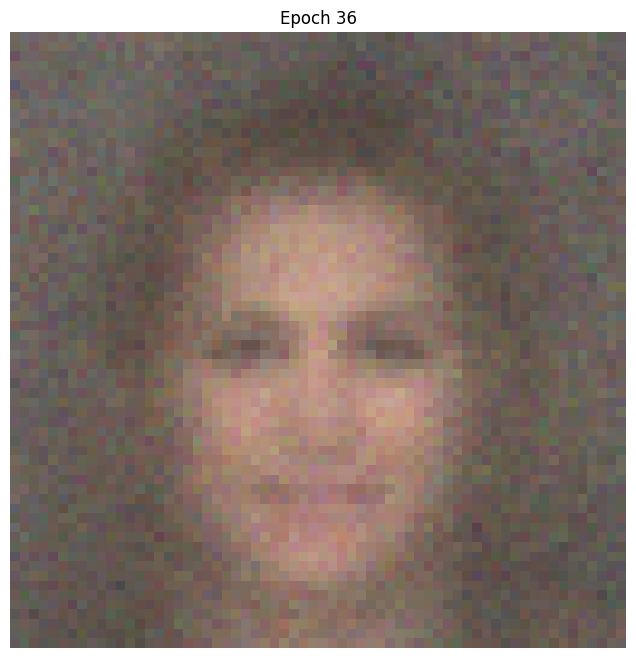

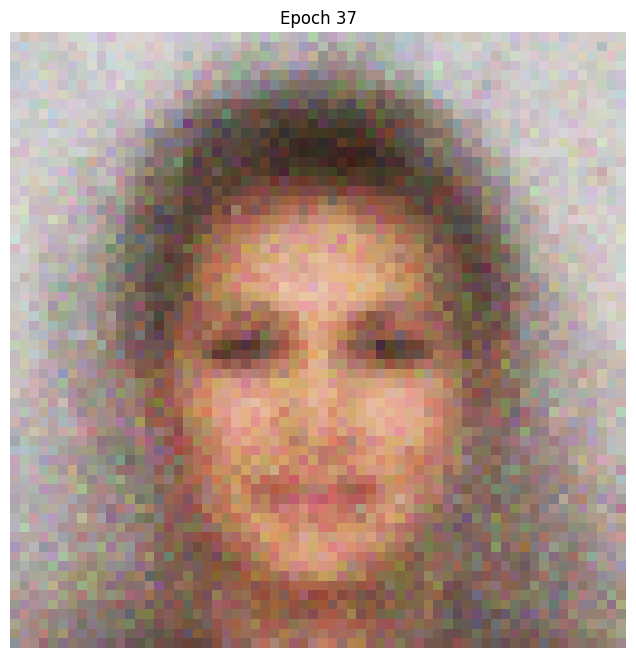

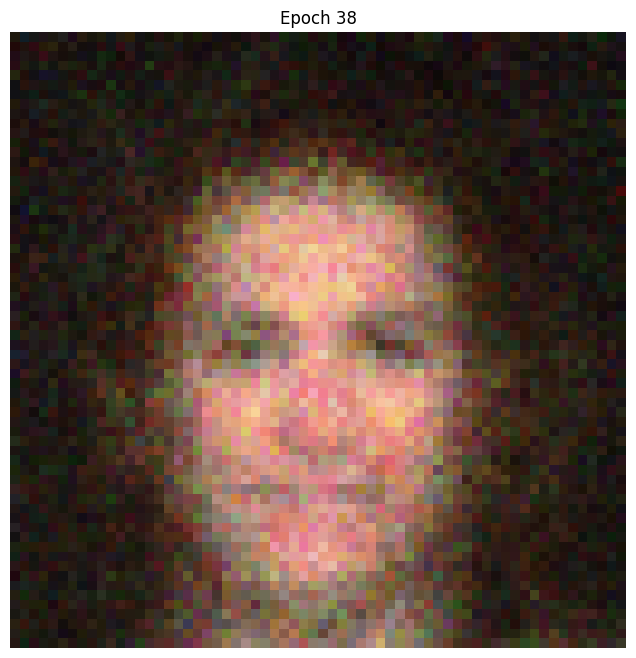

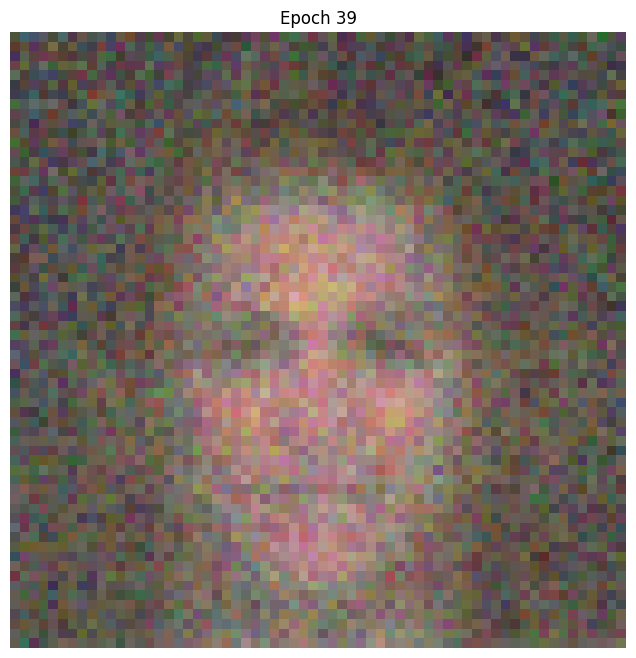

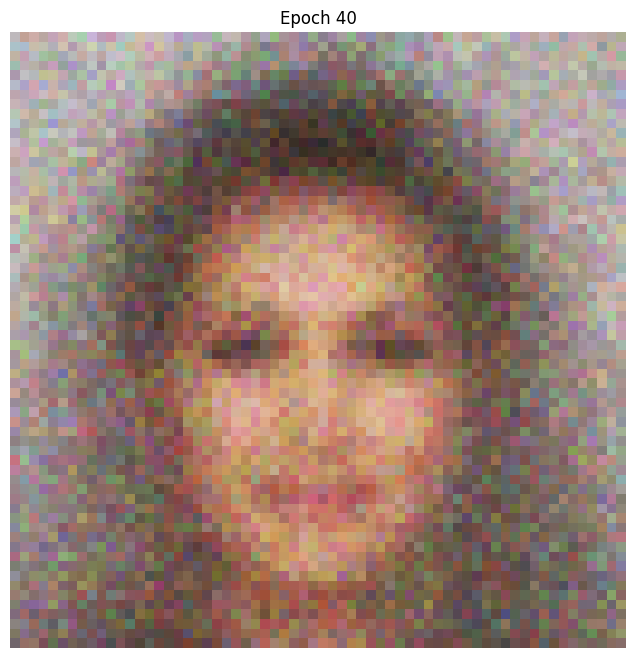

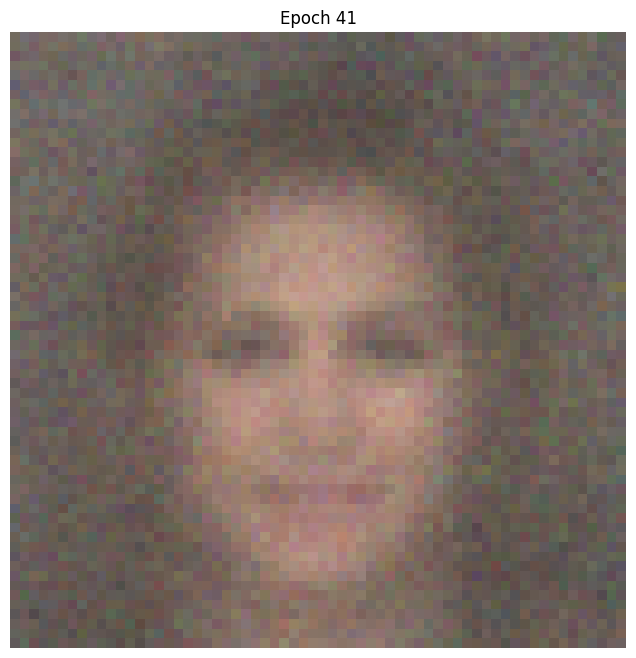

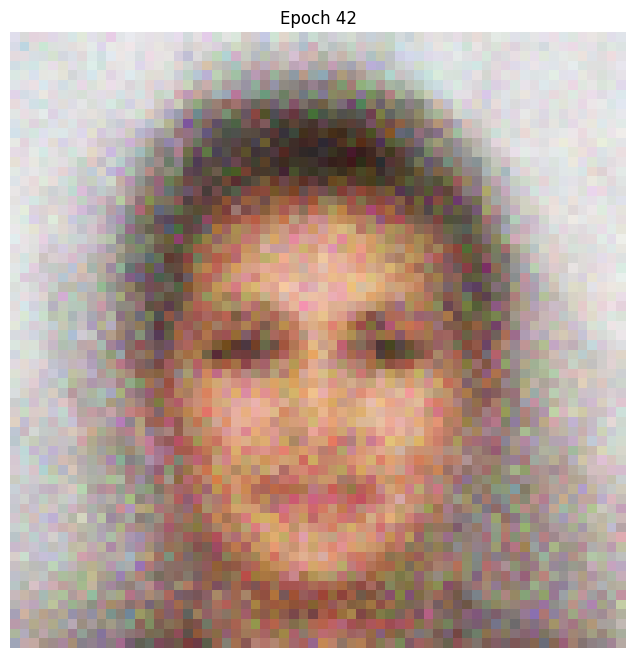

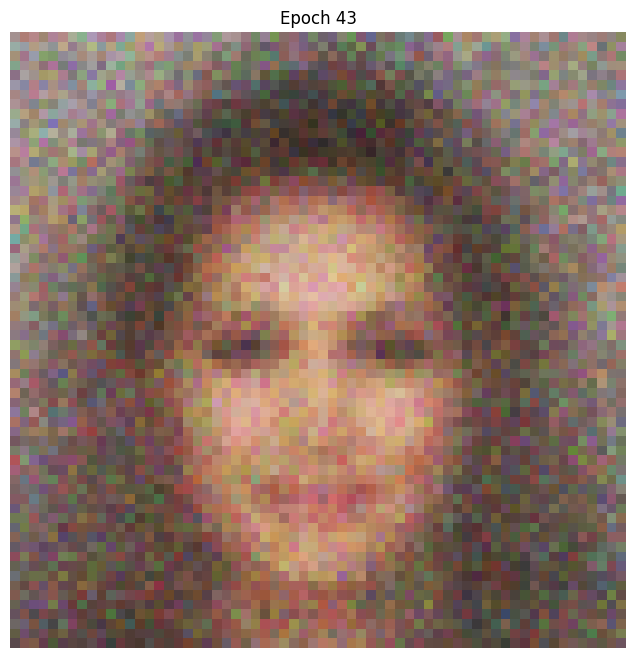

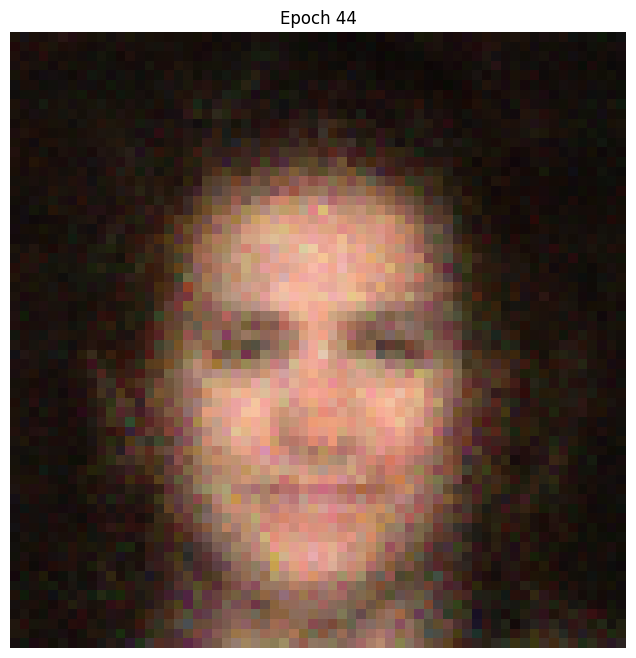

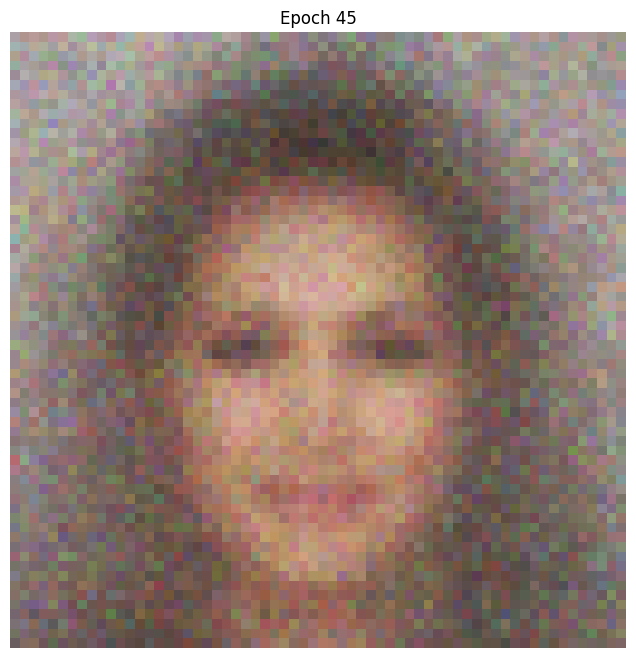

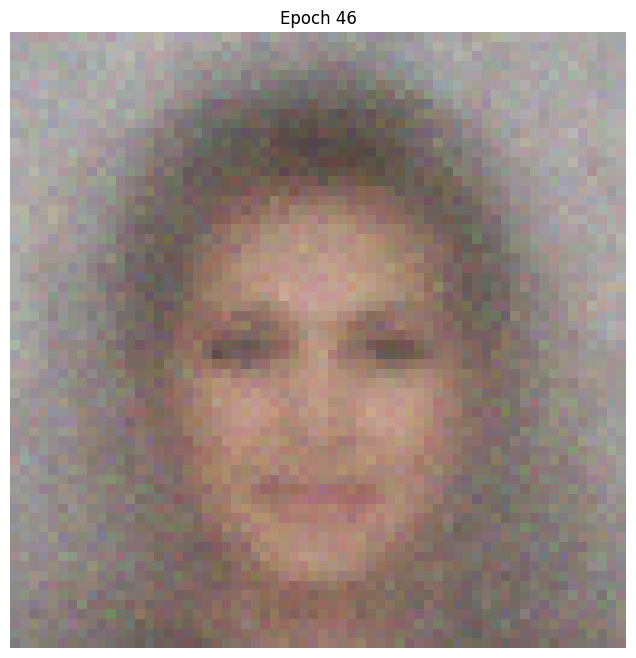

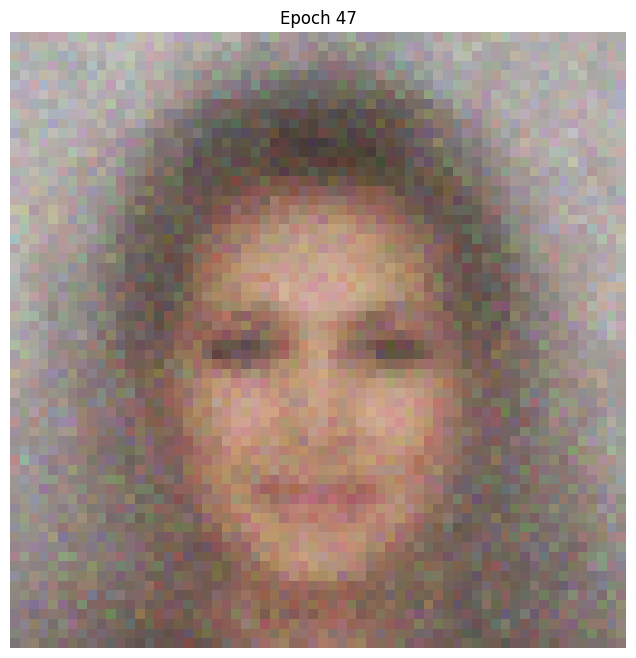

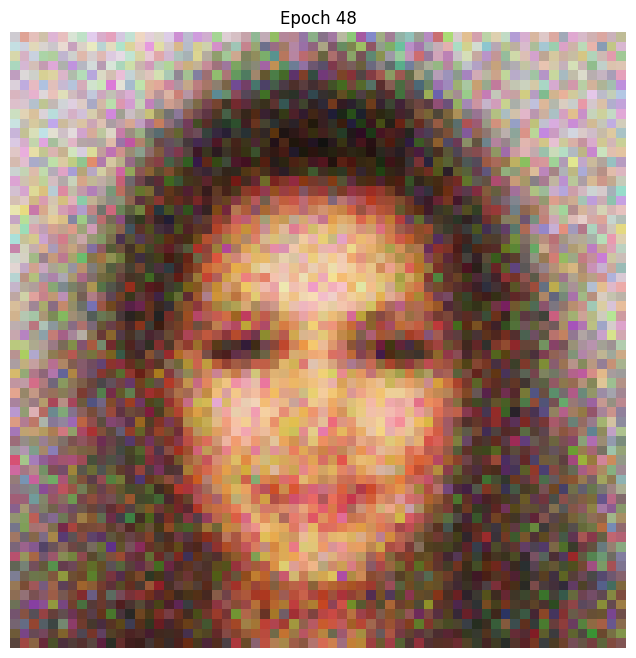

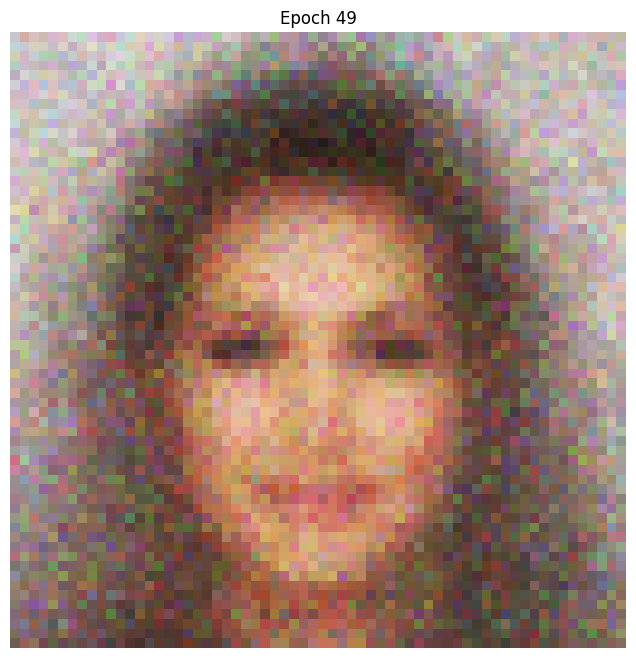

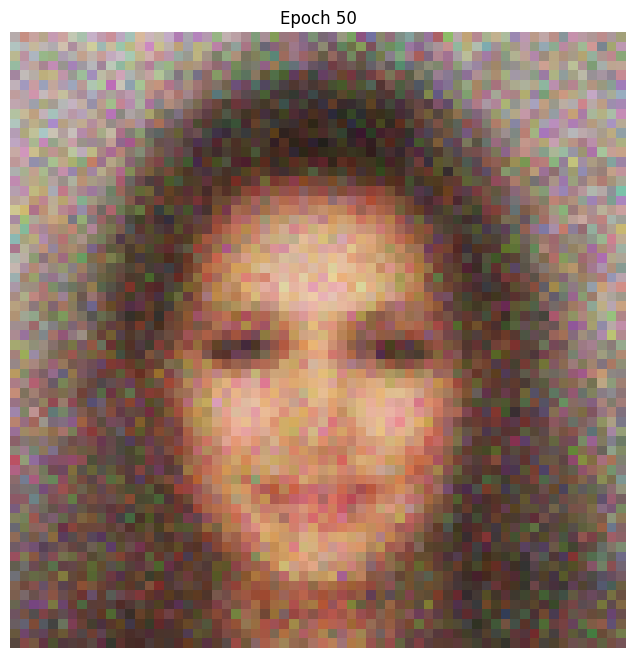

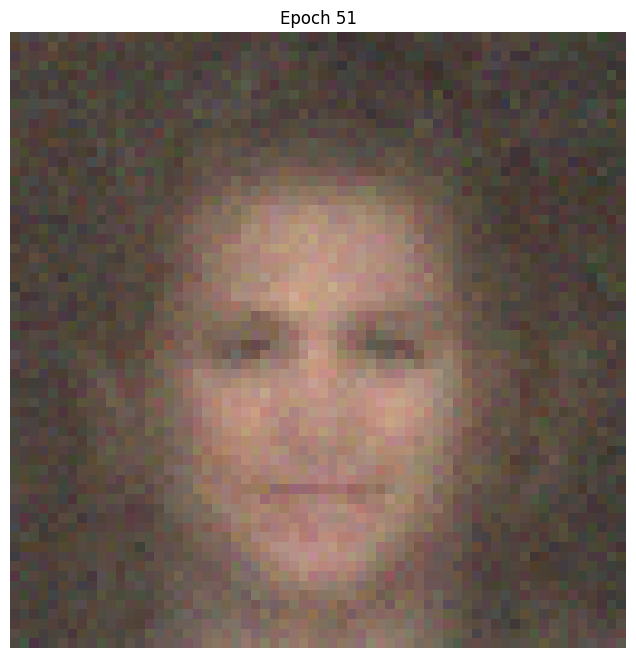

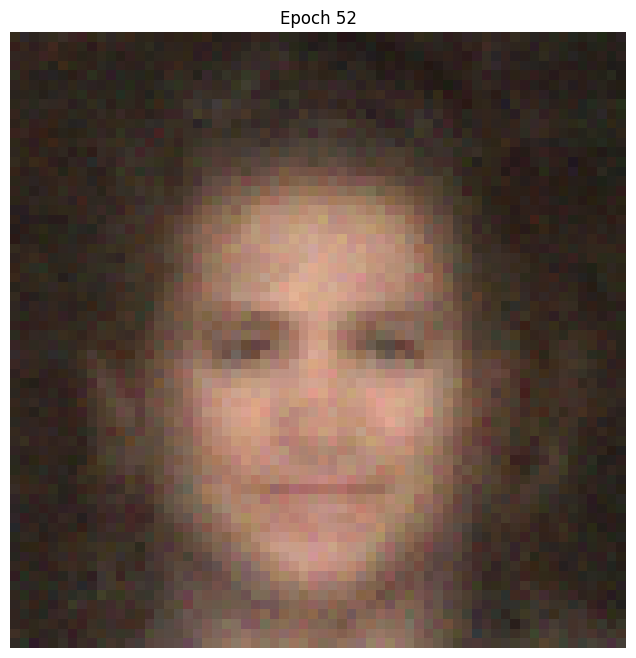

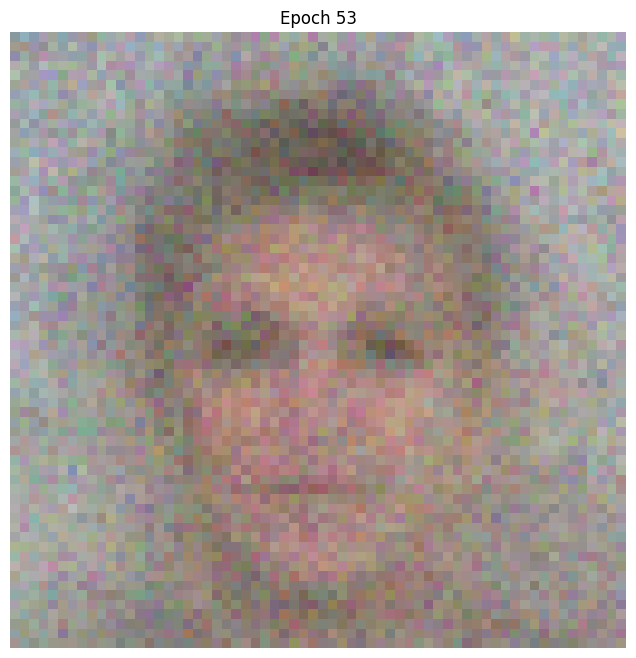

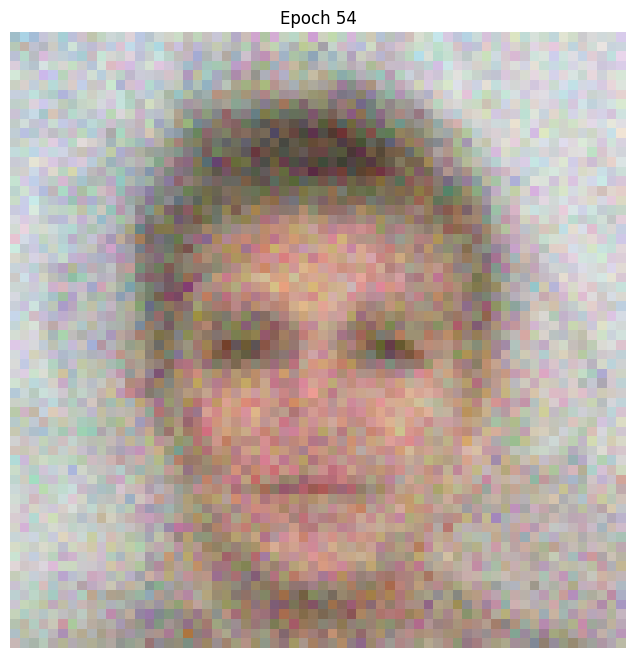

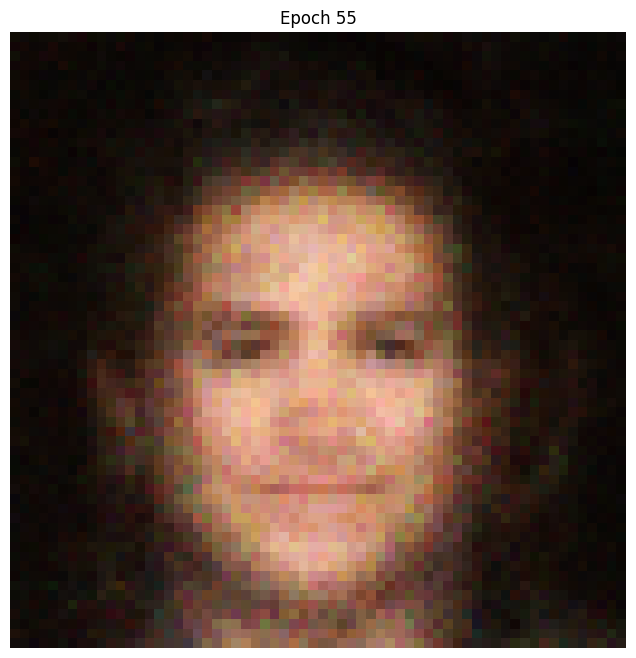

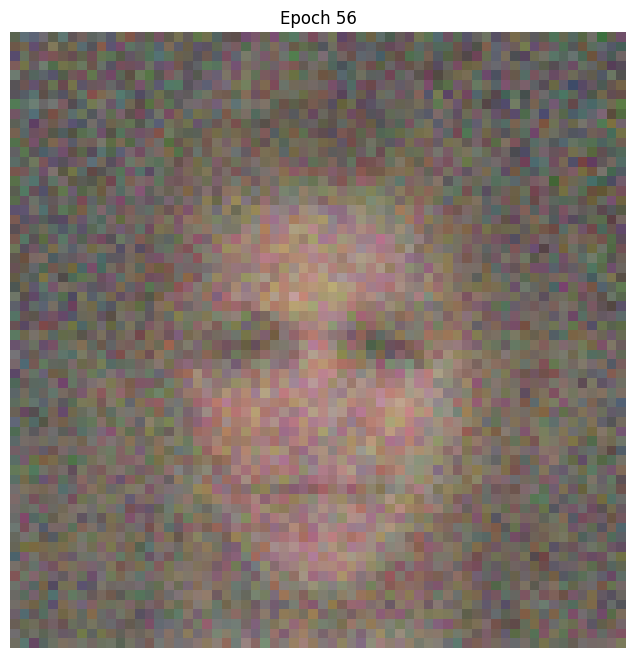

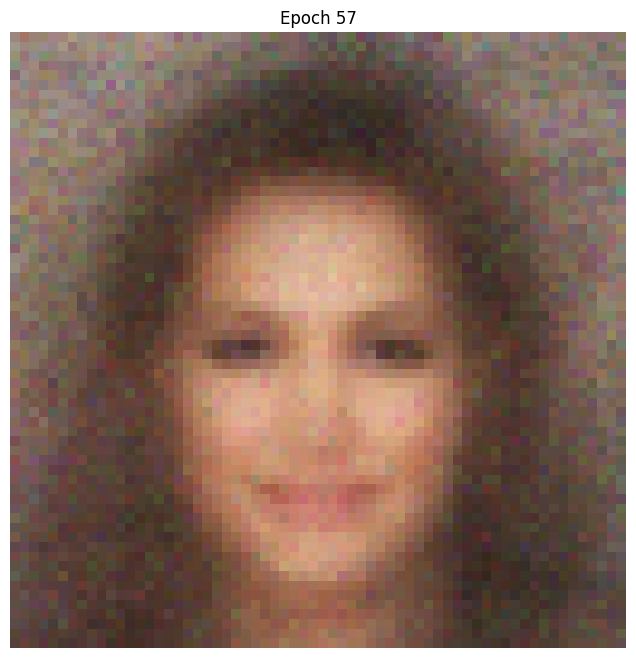

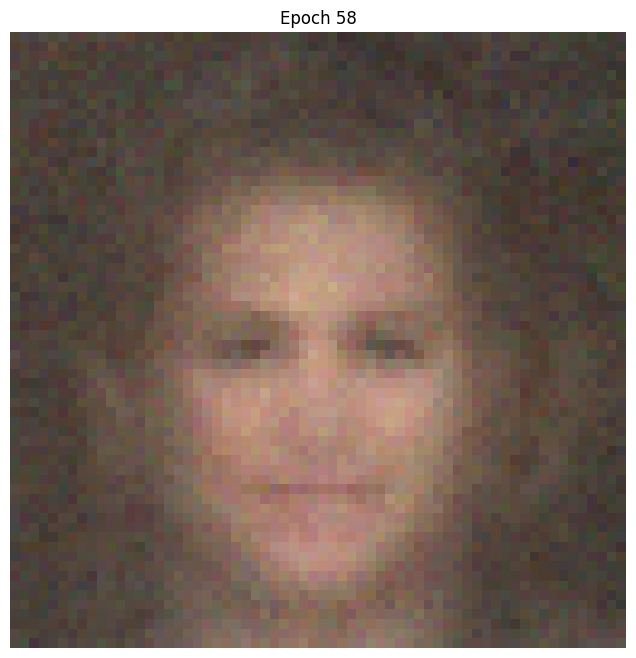

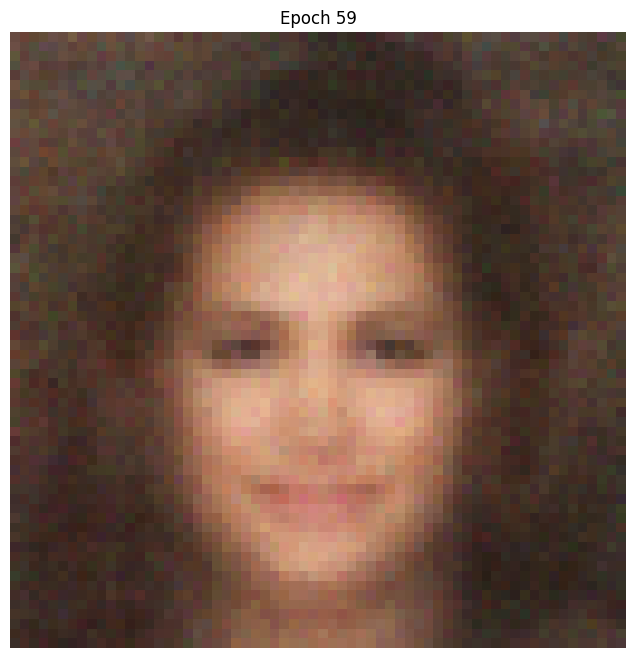

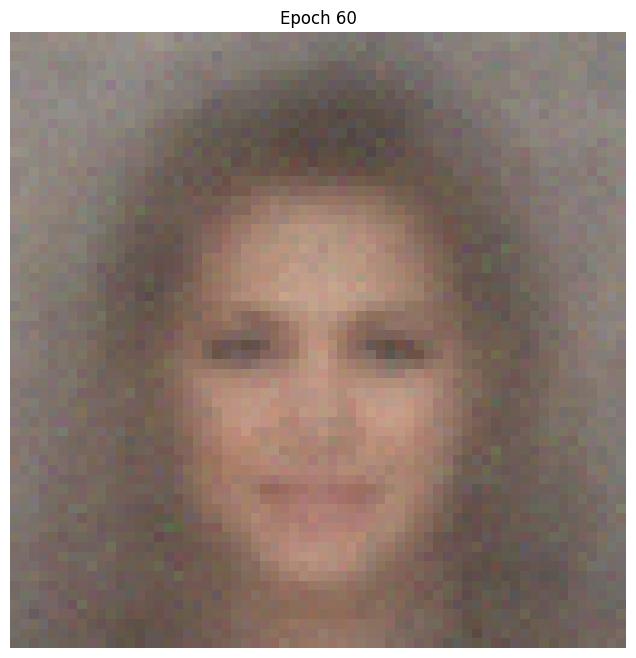

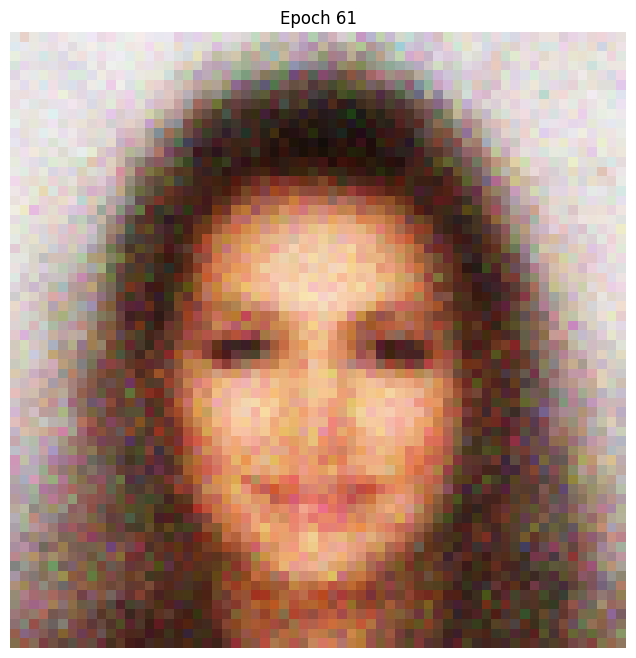

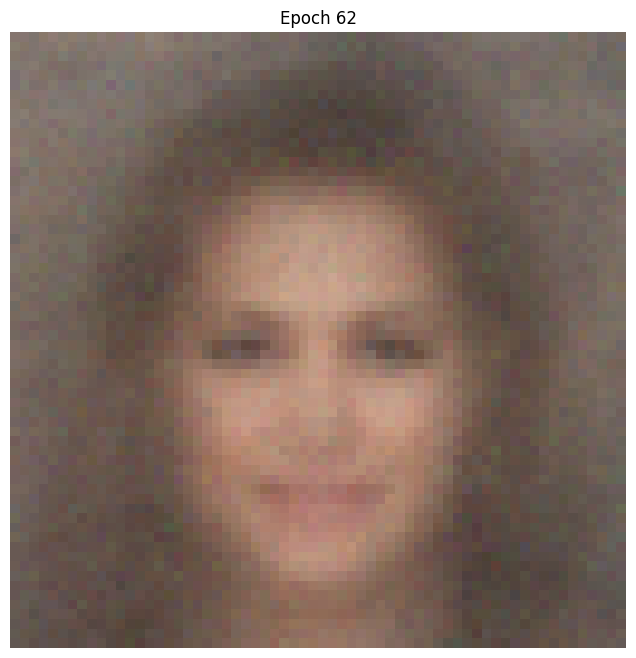

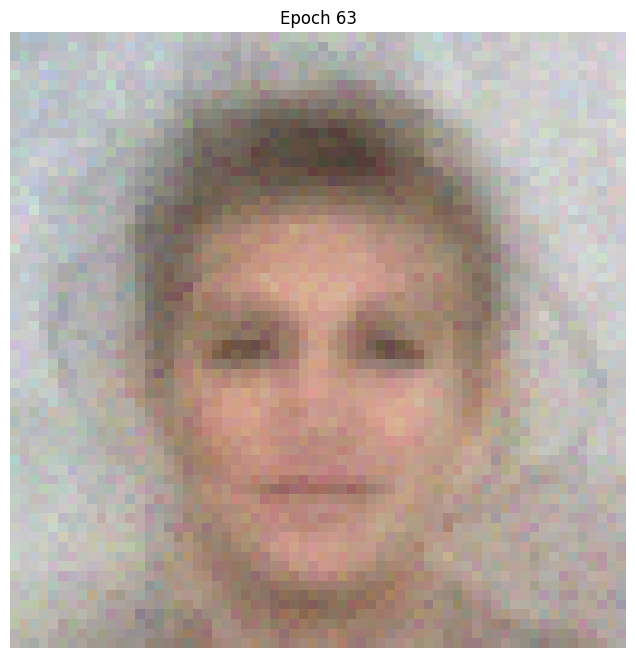

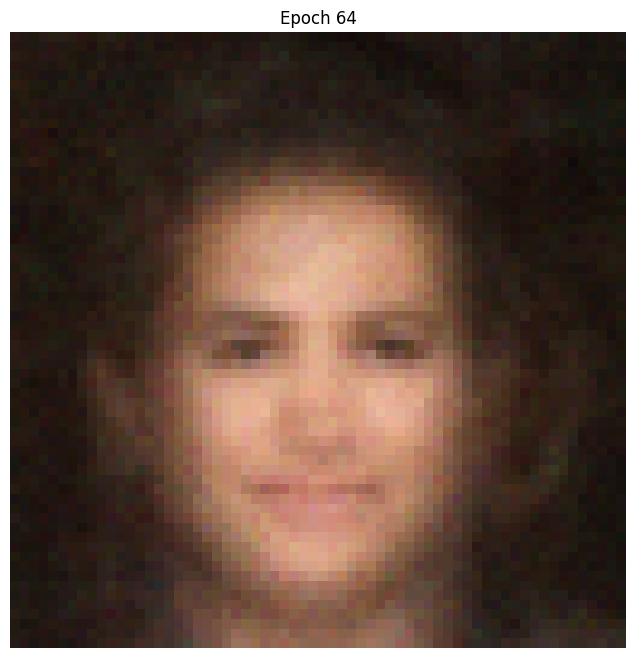

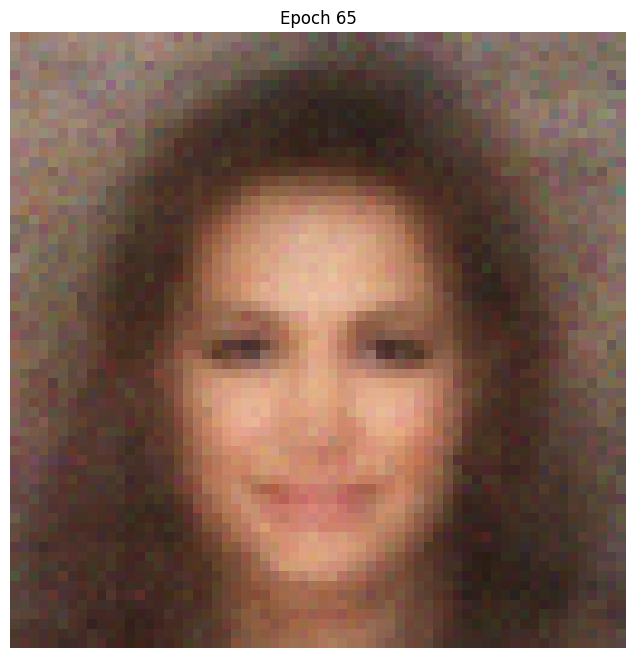

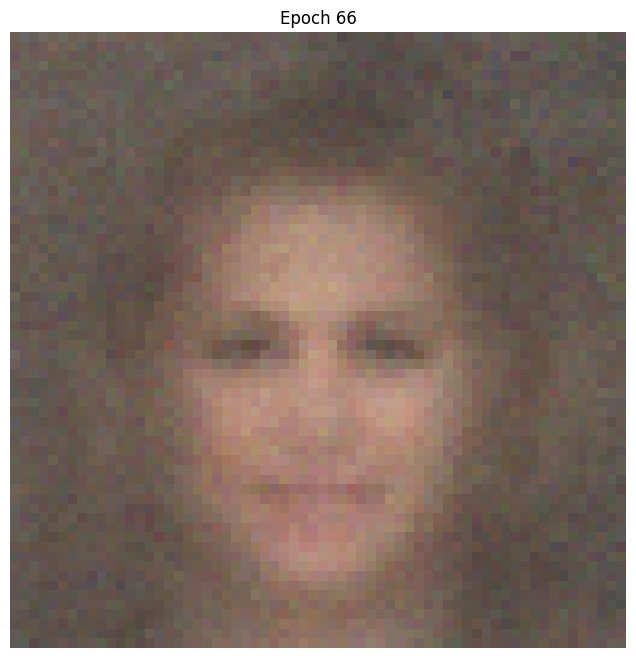

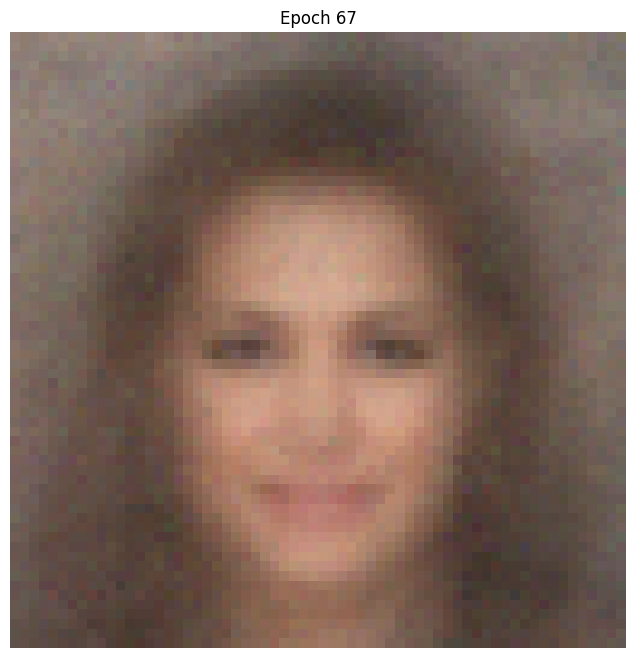

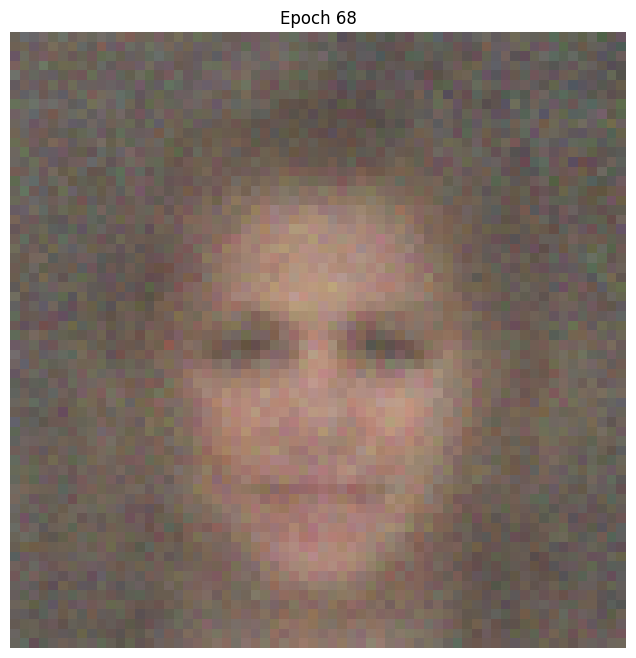

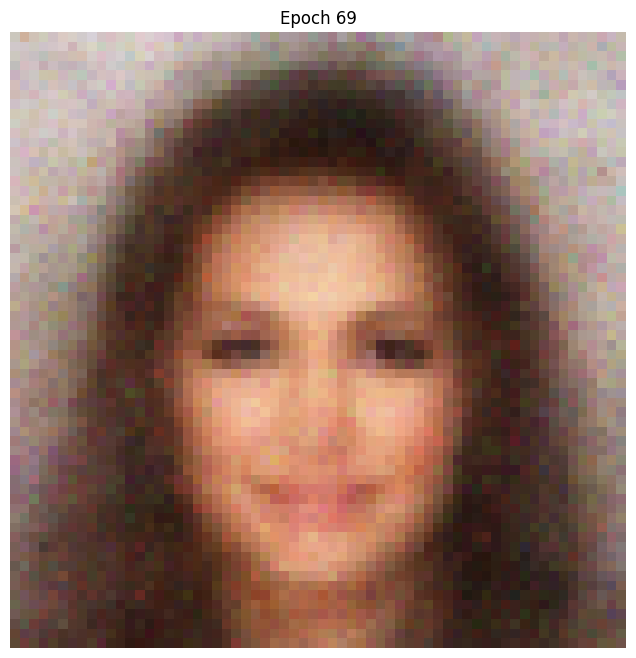

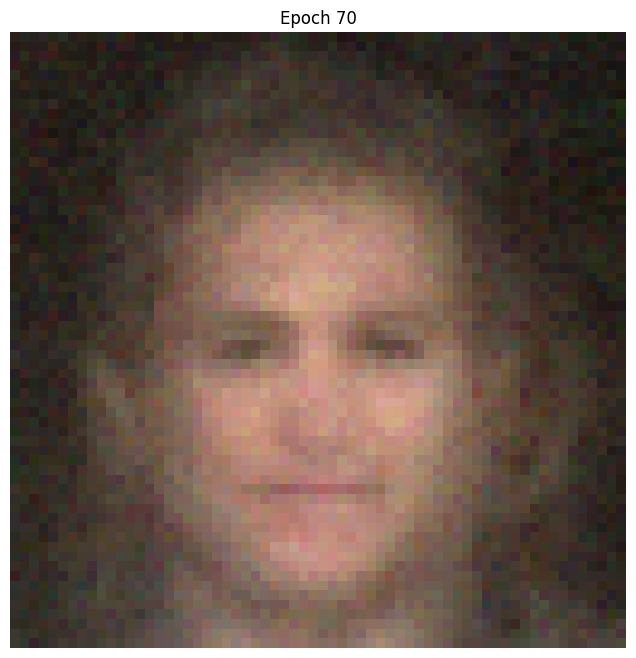

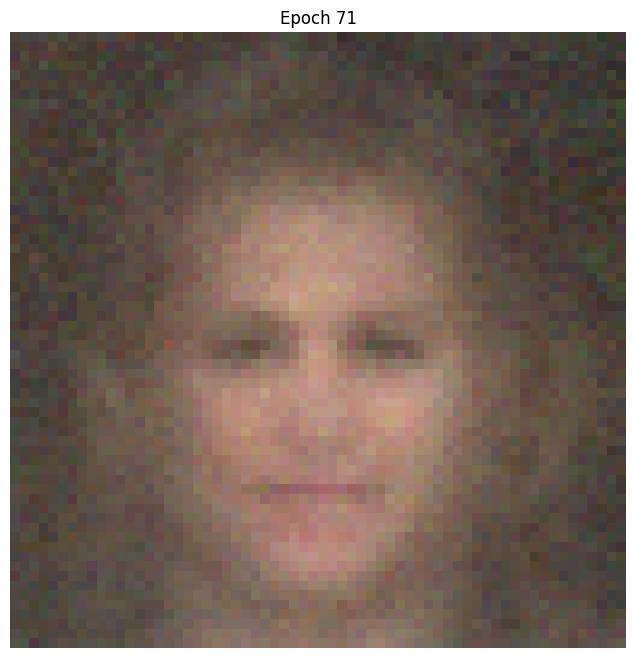

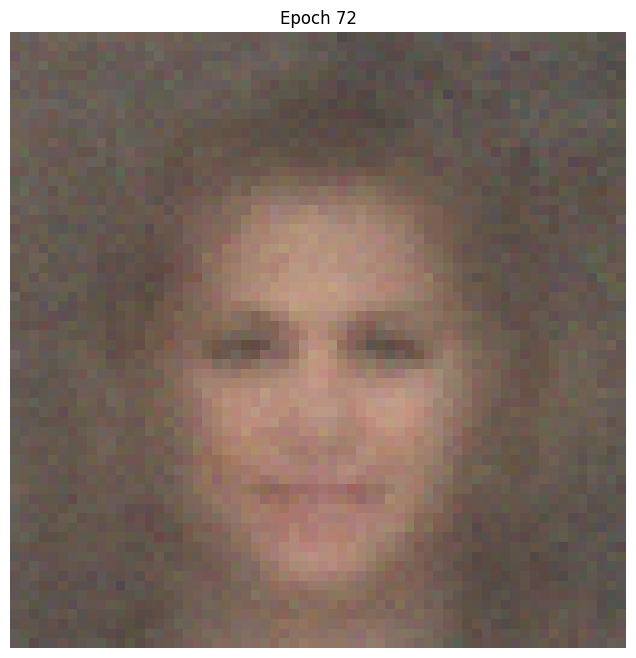

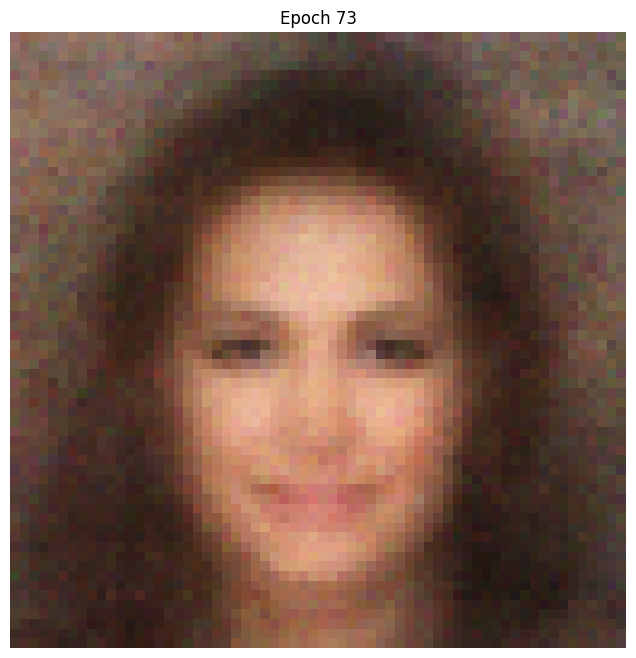

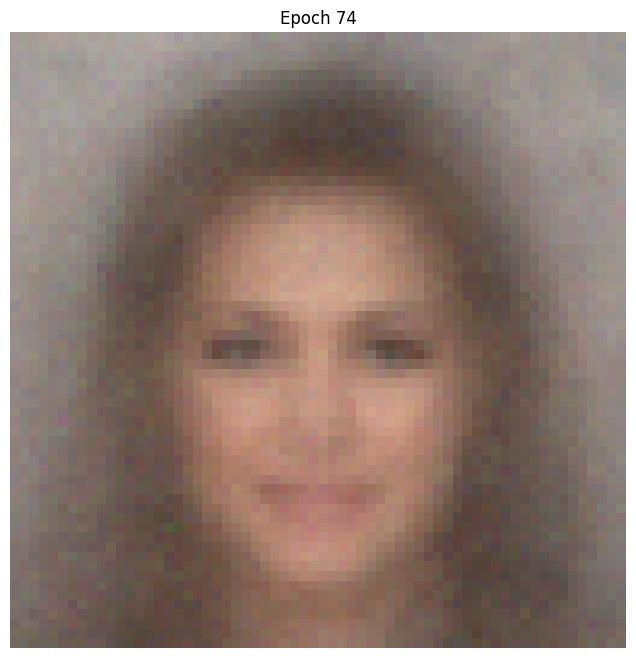

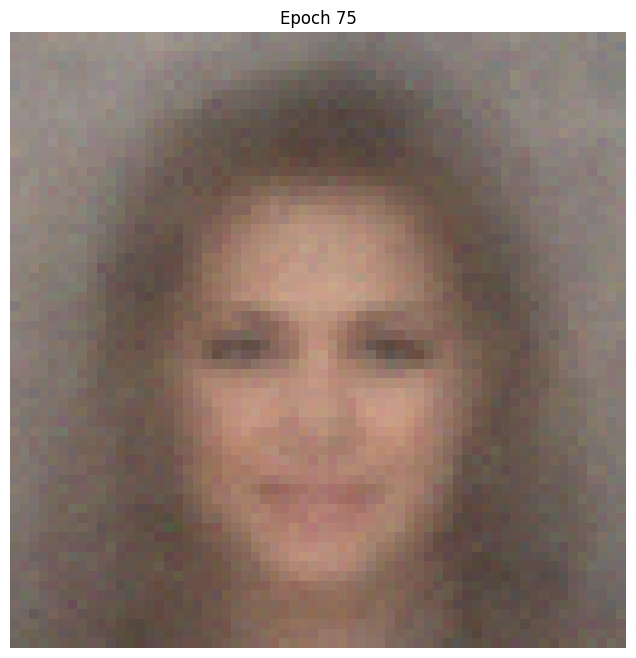

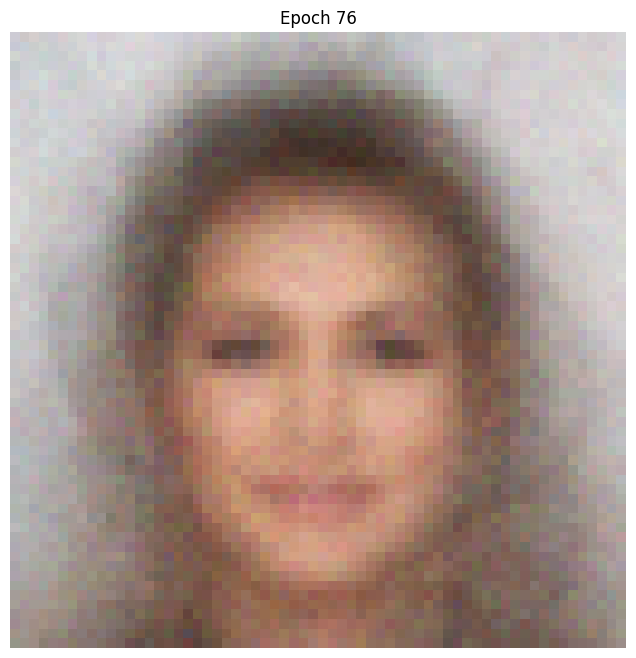

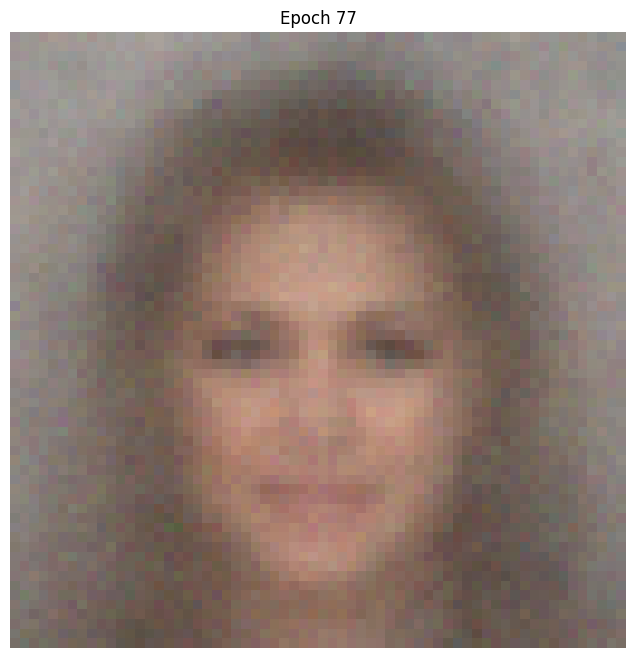

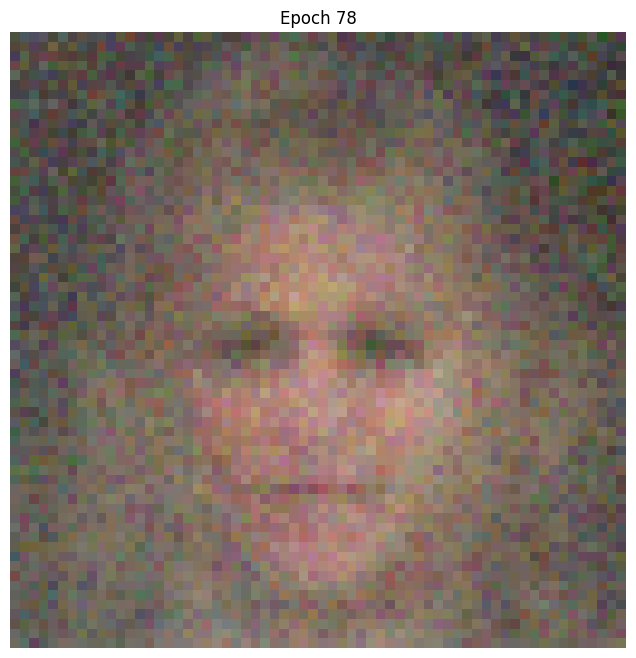

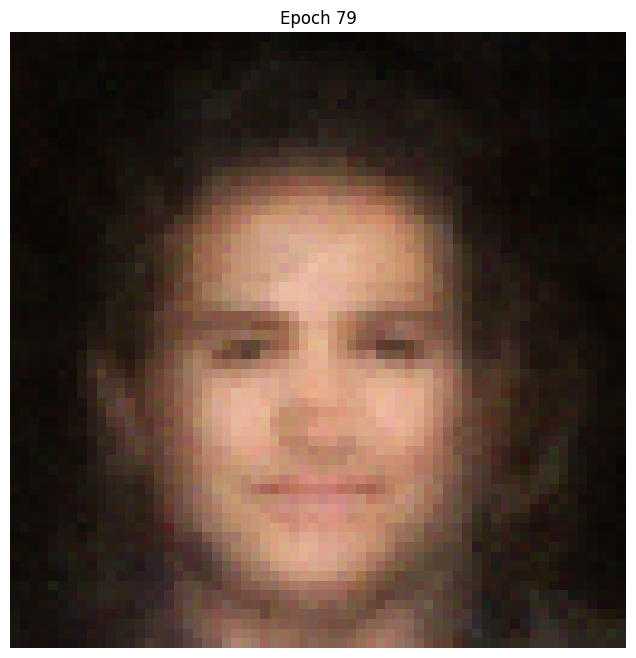

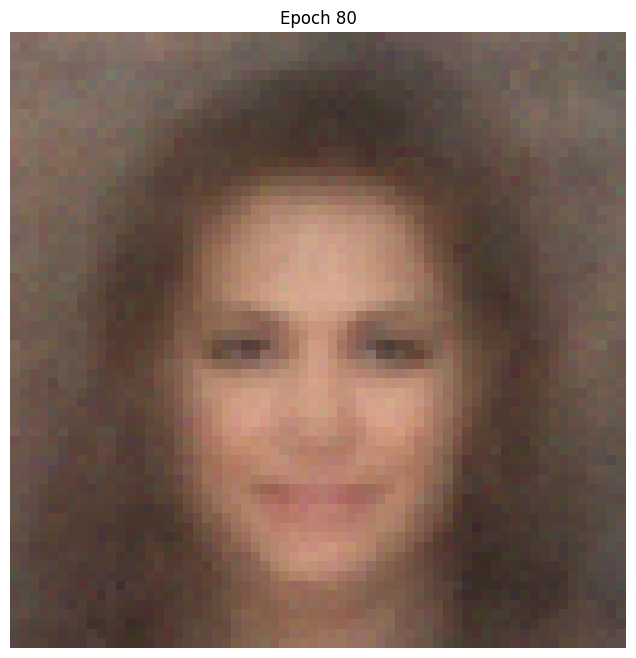

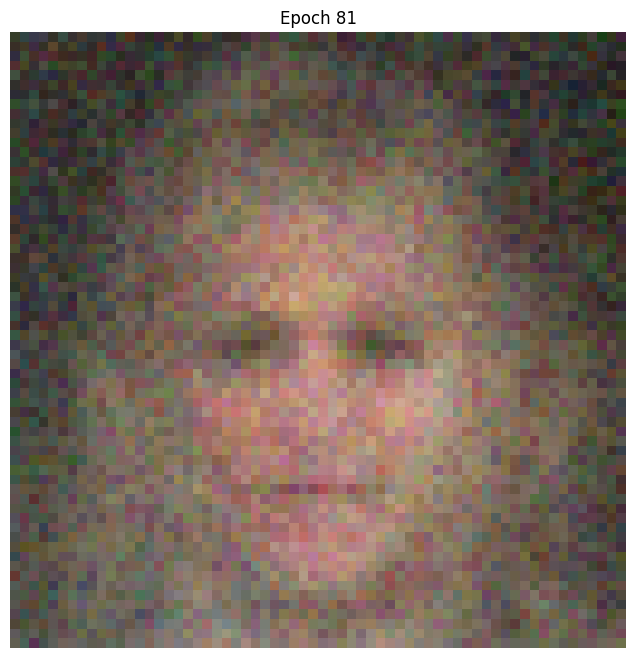

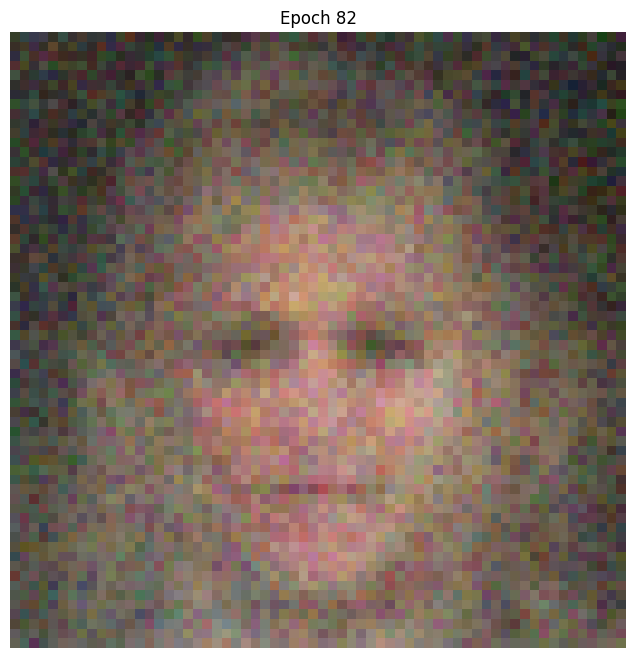

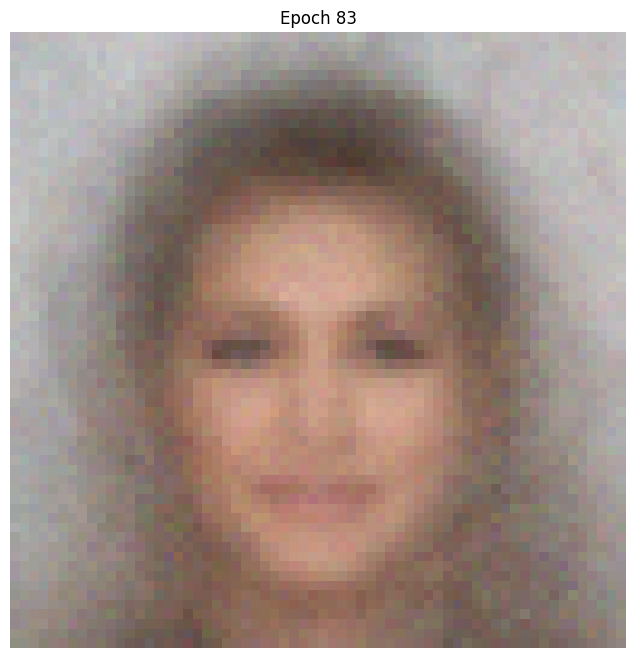

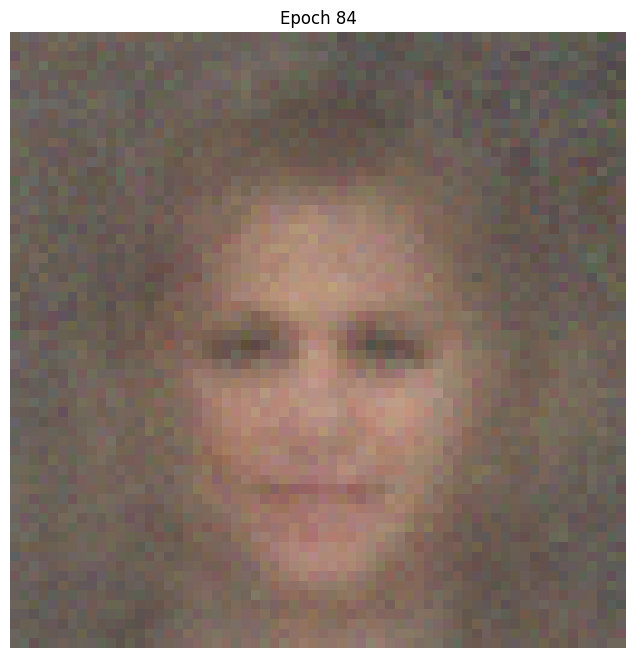

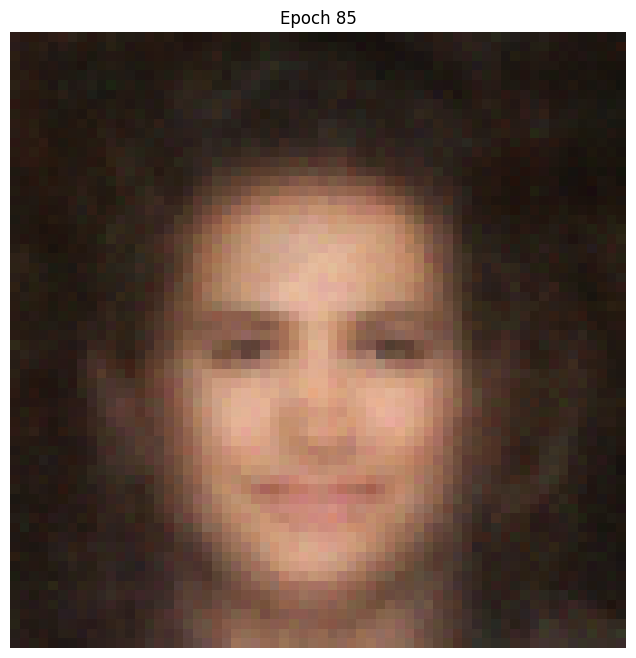

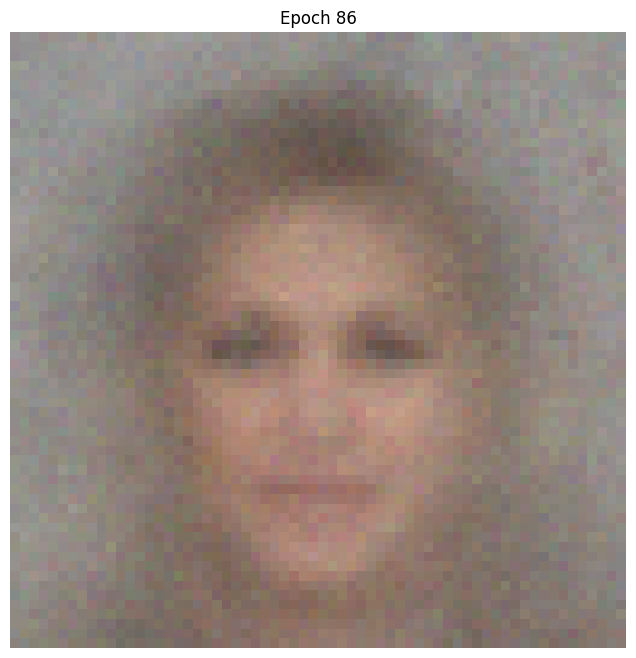

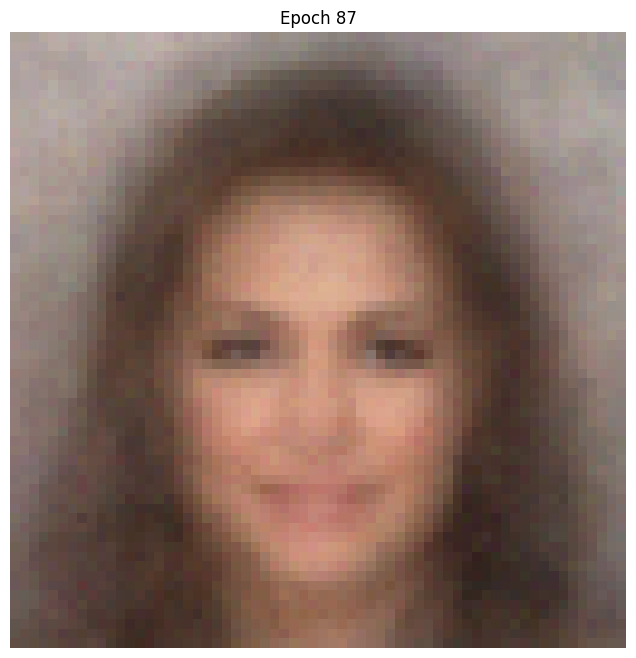

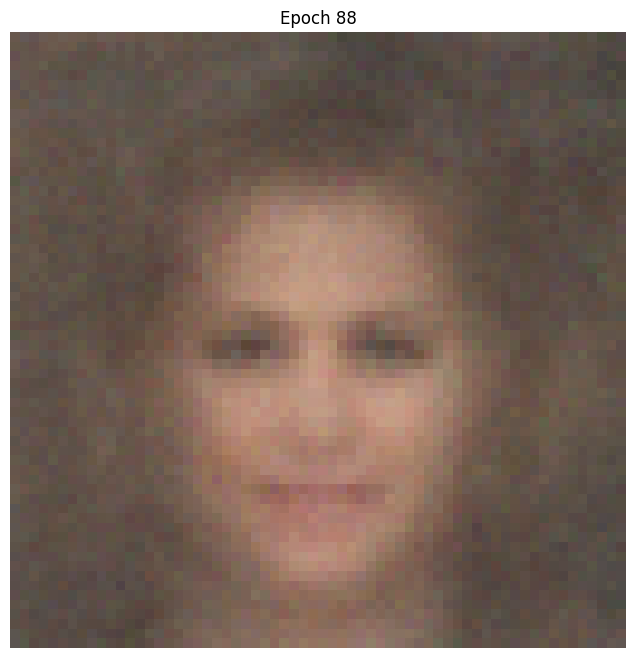

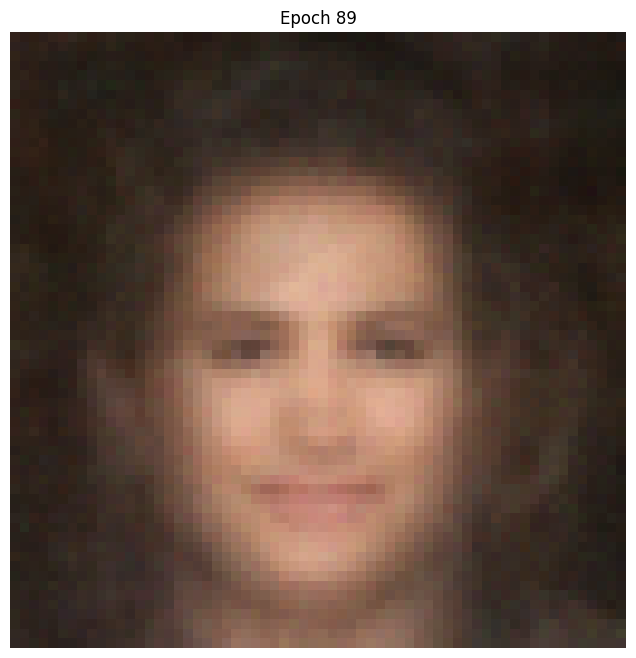

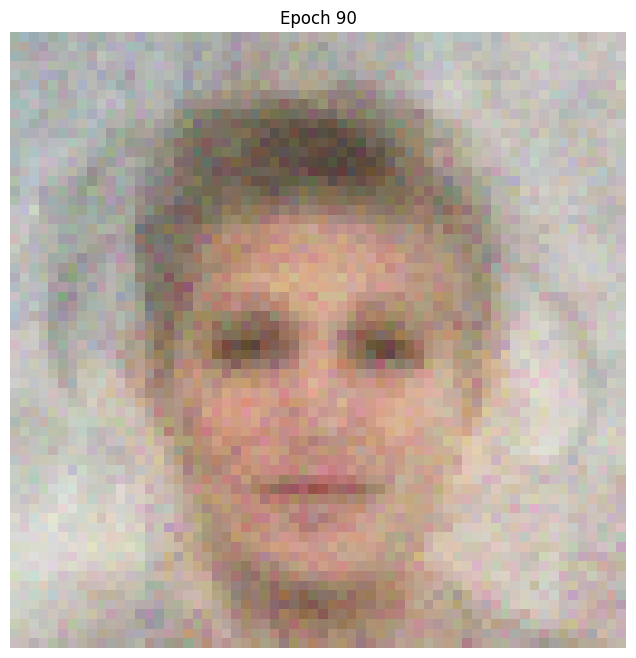

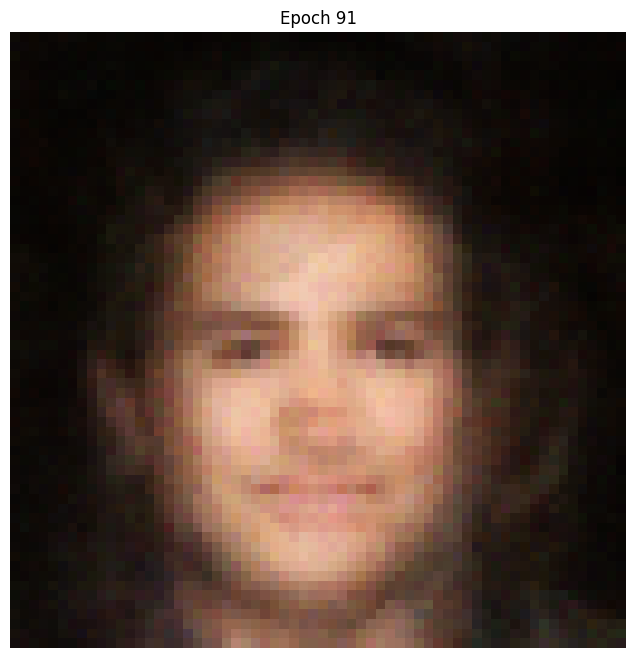

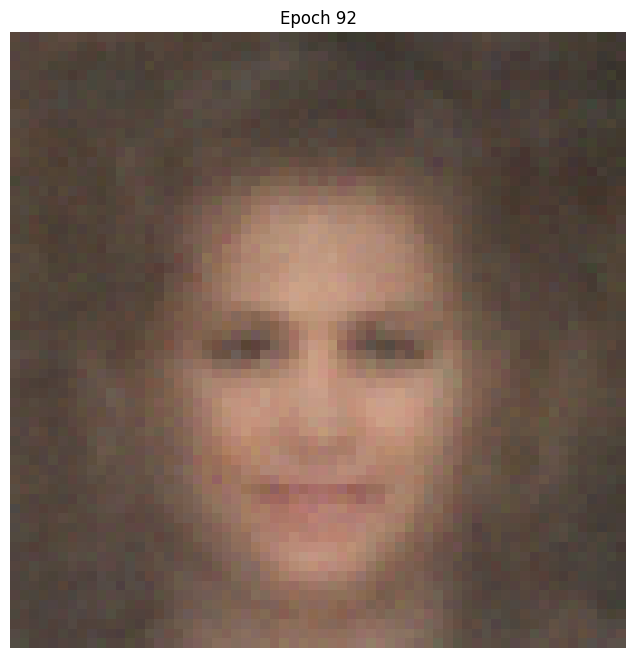

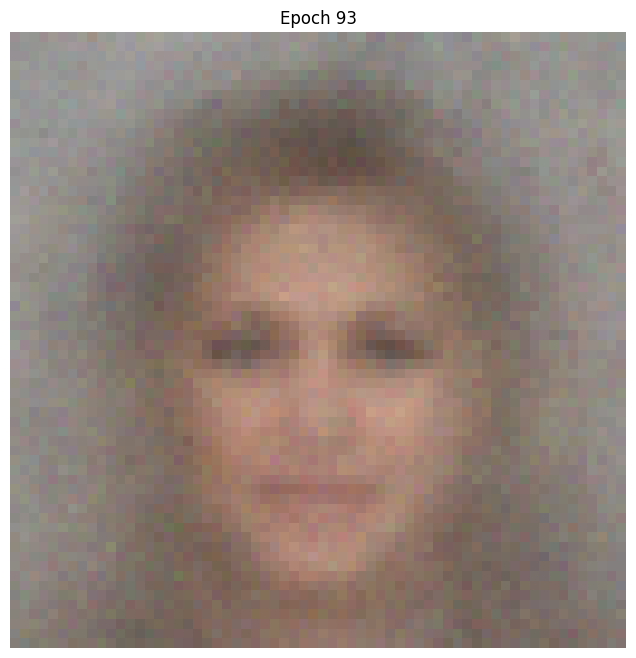

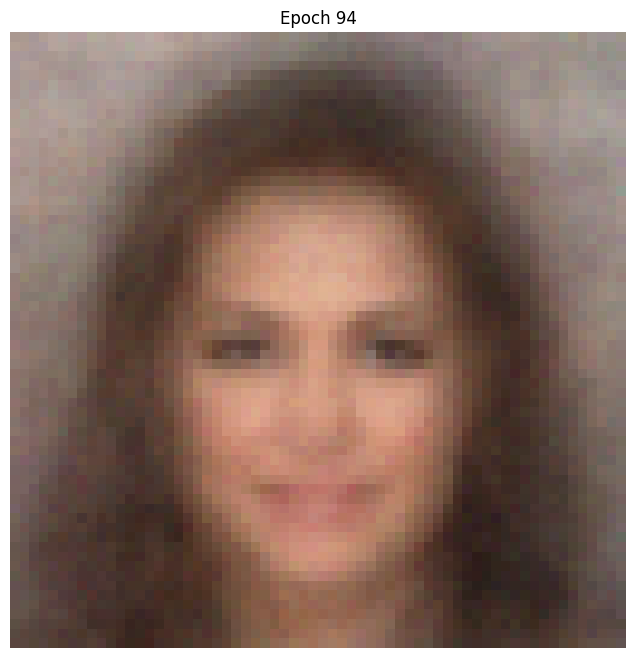

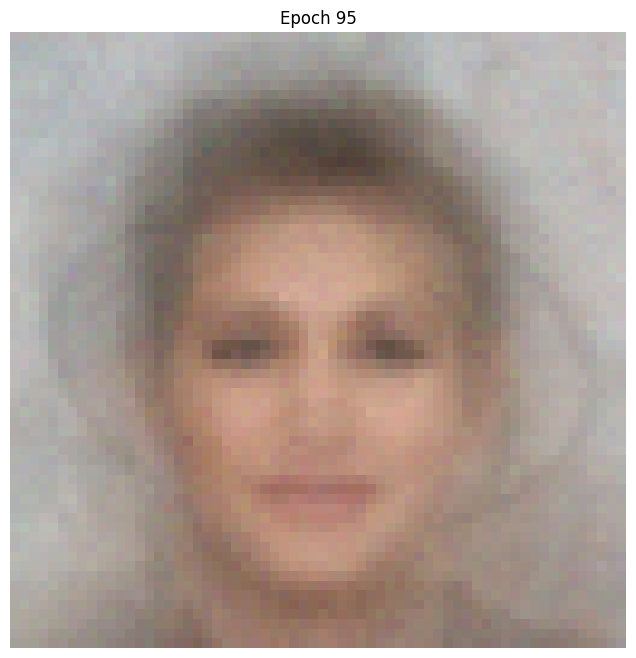

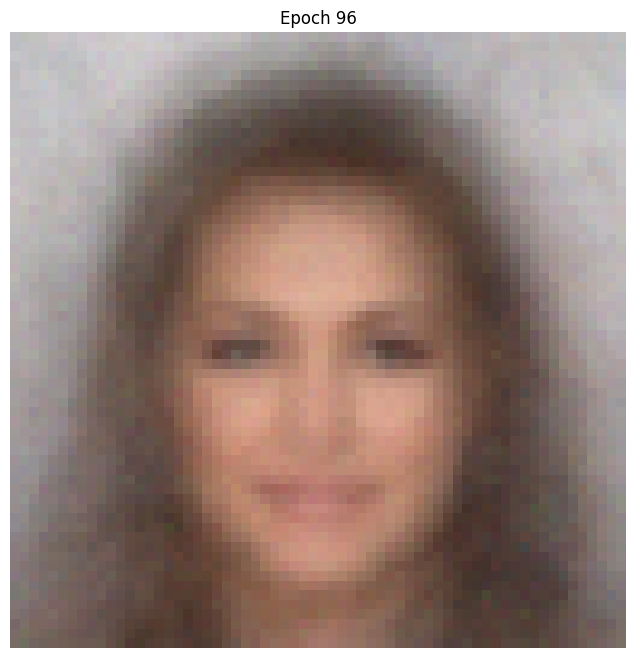

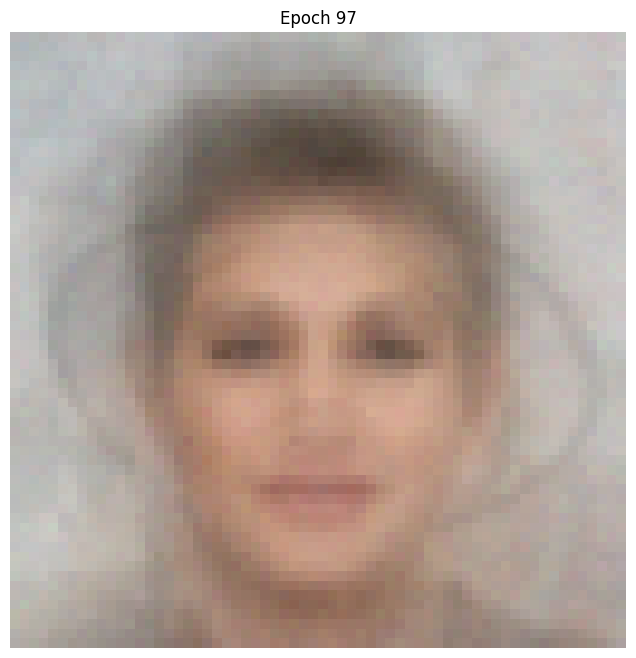

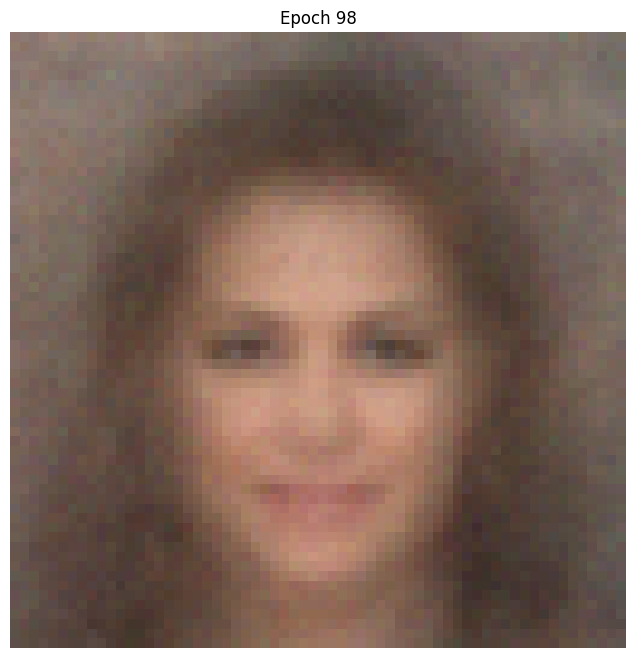

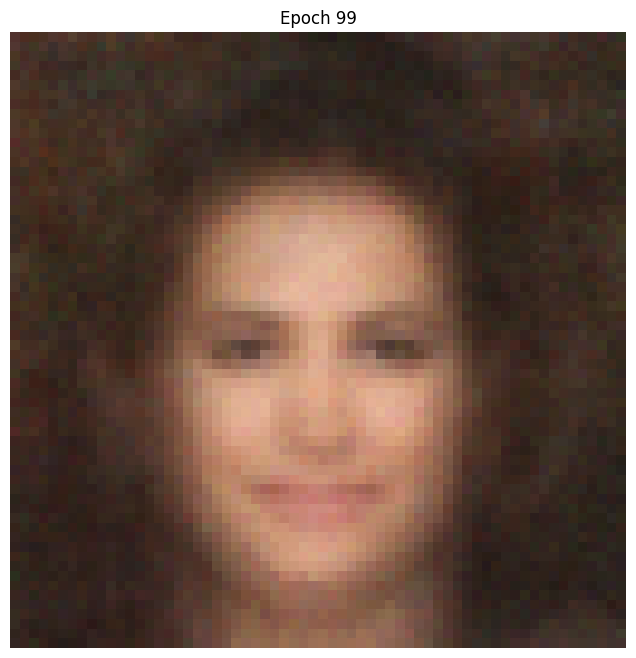

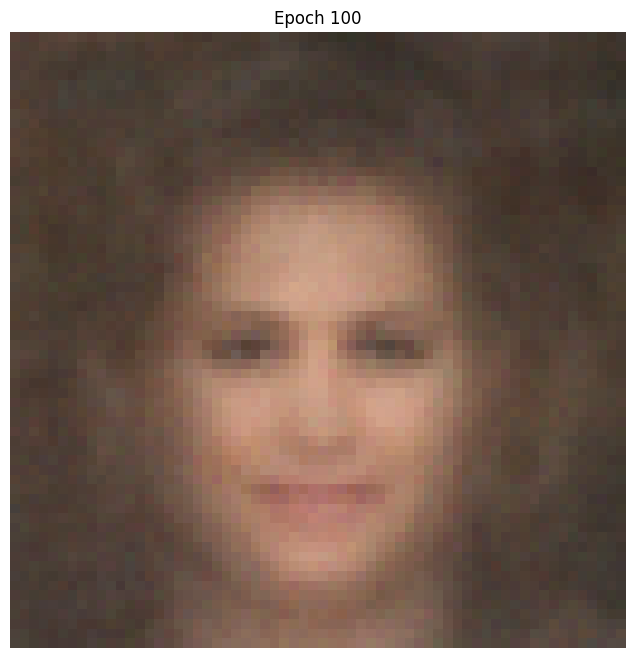

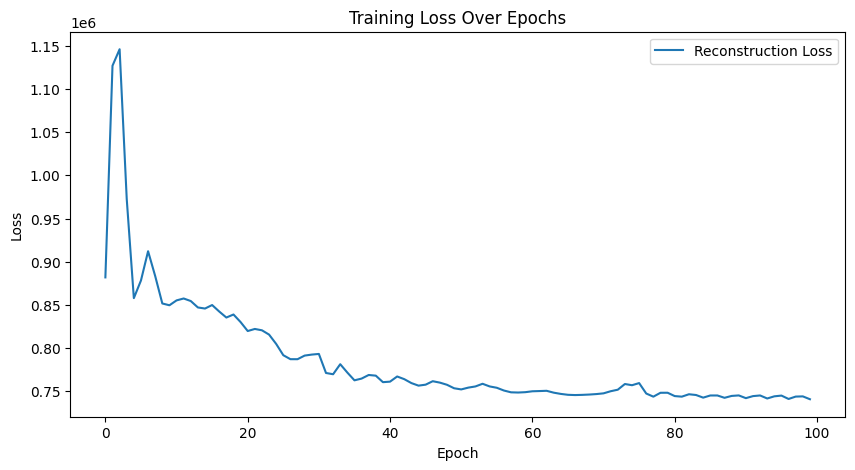

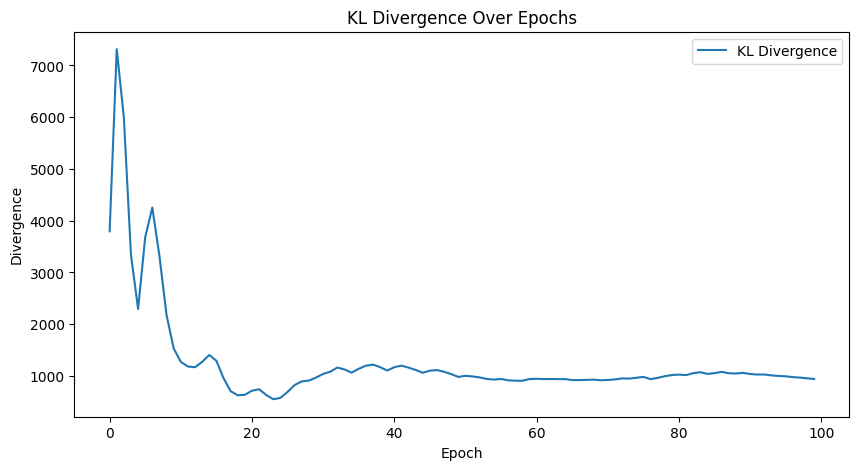

In [ ]:
autoencoder = train(autoencoder, data_loader, epochs=100)

In [ ]:
import pickle

weights = autoencoder.state_dict()
torch.save(weights, 'autoencoder_weights.pkl')

In [ ]:
from sklearn.manifold import TSNE

def visualize_latent_space(encoder, data_loader, num_points=1000):
    # Collect points from the latent space
    points = []
    labels = []
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            mu, _ = encoder(x.to(device))  # Get the mean vector of the latent space distribution
            mu = mu.cpu().numpy()  # Now you can call cpu() on the tensor
            points.append(mu)
            labels.append(y.numpy())
            if (i+1) * data_loader.batch_size >= num_points:
                break

    points = np.concatenate(points, axis=0)[:num_points]
    labels = np.concatenate(labels, axis=0)[:num_points]

    points = TSNE(n_components=2).fit_transform(points)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='tab10', s=2, alpha=0.6)
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.grid(True)
    plt.show()

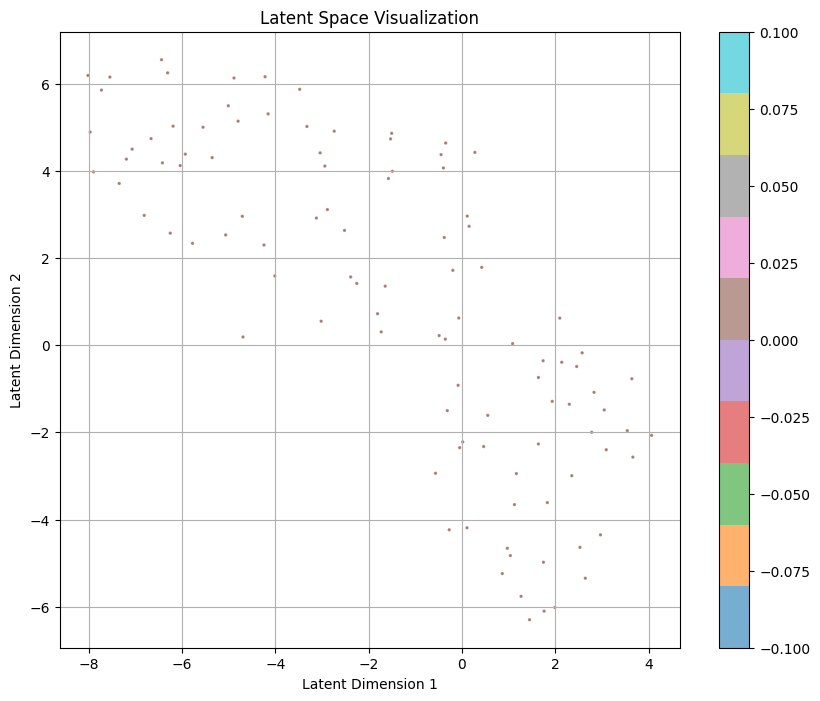

In [ ]:
visualize_latent_space(autoencoder.encoder, data_loader)